[Import](#import)
\
[Data Processing](#Data_Processing) 
\
[Analiza brakujących wartości oraz wartości unikalnych](#null)
\
[EDA](#eda)
\
[Feature engineering - zmiana typów, tworzenie nowych zmiennych](#feature)
\
[Analiza wartości odstających](#outlier)
\
[Analiza zależności](#corr): [FICO](#fico), [wiek kredytowy](#age), [własność domu](#home), [roczny dochód](#inc), [historia zatrudnienia](#emp), [wysokość kredytu](#loan)
\
[Standaryzacja zmiennych numerycznych i zamiana kategorycznych na dummies](#std)
\
[Klasteryzacja](#clust): [KMeans](#kmean), [DBSCAN](#dbscan)
\
[Modele klasyfikujące](#models): [Regresja logistyczna](#logist1), [Drzewo decyzyjne](#tree), [Las losowy](#forest), [SVC](#svc), [XGBoost](#xgb)
\
[PCA](#pca): [Modele ze zmiennymi pc](#pc_models)
\
[Finalny model](#final)

<a id='import'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(style='darkgrid')

In [3]:
from sklearn import preprocessing, metrics, tree
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

In [4]:
from scipy import stats

In [5]:
from sklearn.cluster import KMeans, DBSCAN

In [6]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [295]:
from sklearn.svm import SVC

In [323]:
import xgboost as xgb

In [378]:
from sklearn.decomposition import PCA

In [8]:
loan = pd.read_csv('Loan_data_no_semi.csv',low_memory=False)

In [9]:
loan.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501        NaN     5000.0       5000.0           4975.0   36 months   
1  1077430        NaN     2500.0       2500.0           2500.0   60 months   
2  1077175        NaN     2400.0       2400.0           2400.0   36 months   
3  1076863        NaN    10000.0      10000.0          10000.0   36 months   
4  1075358        NaN     3000.0       3000.0           3000.0   60 months   

  int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0   10.65%       162.87     B        B2  ...                            NaN   
1   15.27%        59.83     C        C4  ...                            NaN   
2   15.96%        84.33     C        C5  ...                            NaN   
3   13.49%       339.31     C        C1  ...                            NaN   
4   12.69%        67.79     B        B5  ...                            NaN   

  hardship_last_payment_amount disbursement_method  debt_settlement_flag  \
0                          NaN                Cash                     N   
1                          NaN                Cash                     N   
2                          NaN                Cash                     N   
3                          NaN                Cash                     N   
4                          NaN                Cash                     N   

  debt_settlement_flag_date settlement_status settlement_date  \
0                       NaN               NaN             NaN   
1                       NaN               NaN             NaN   
2                       NaN               NaN             NaN   
3                       NaN               NaN             NaN   
4                       NaN               NaN             NaN   

  settlement_amount settlement_percentage settlement_term  
0               NaN                   NaN             NaN  
1               NaN                   NaN             NaN  
2               NaN                   NaN             NaN  
3               NaN                   NaN             NaN  
4               NaN                   NaN             NaN  

[5 rows x 151 columns]

<a id='Data_Processing'></a>
## Data Processing

In [10]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42536 entries, 0 to 42535
Columns: 151 entries, id to settlement_term
dtypes: float64(120), object(31)
memory usage: 49.0+ MB


In [11]:
loan.loan_status.value_counts()

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

In [12]:
loan.loc[loan['loan_status']=='Does not meet the credit policy. Status:Fully Paid','loan_status']='Fully Paid'
loan.loc[loan['loan_status']=='Does not meet the credit policy. Status:Charged Off','loan_status']='Charged Off'

In [13]:
loan.loan_status.value_counts()

Fully Paid     36104
Charged Off     6431
Name: loan_status, dtype: int64

<a id='null'></a>
### Analiza pustych zmiennych

In [14]:
loan.isnull().sum()[loan.isnull().sum()==42536]

member_id                                     42536
mths_since_last_major_derog                   42536
annual_inc_joint                              42536
dti_joint                                     42536
verification_status_joint                     42536
                                              ...  
hardship_dpd                                  42536
hardship_loan_status                          42536
orig_projected_additional_accrued_interest    42536
hardship_payoff_balance_amount                42536
hardship_last_payment_amount                  42536
Length: 82, dtype: int64

In [15]:
empty_cols = list(loan.isnull().sum()[loan.isnull().sum()==42536].index)

#### Puste kolumny nie zawierające żadnych wartości nie dodają informacji, więc mogą być usunięte

In [16]:
loan.drop(columns=empty_cols,inplace=True)

In [17]:
loan.shape

(42536, 69)

In [18]:
loan.isnull().sum()[loan.isnull().sum()>(0.5*42536)]

mths_since_last_delinq       26927
mths_since_last_record       38885
next_pymnt_d                 39787
debt_settlement_flag_date    42376
settlement_status            42376
settlement_date              42376
settlement_amount            42376
settlement_percentage        42376
settlement_term              42376
dtype: int64

In [19]:
half_empty_cols = list(loan.isnull().sum()[loan.isnull().sum()>(0.5*42536)].index)

In [20]:
half_empty_cols_status = pd.merge(loan[half_empty_cols],loan['loan_status'],left_index=True, right_index=True)
half_empty_cols_status

mths_since_last_delinq  mths_since_last_record next_pymnt_d  \
0                         NaN                     NaN          NaN   
1                         NaN                     NaN          NaN   
2                         NaN                     NaN          NaN   
3                        35.0                     NaN          NaN   
4                        38.0                     NaN          NaN   
...                       ...                     ...          ...   
42531                     NaN                     NaN     Mar-2008   
42532                     NaN                     NaN     Jul-2010   
42533                     NaN                     NaN     Jul-2010   
42534                     NaN                     NaN     Jul-2010   
42535                     NaN                     NaN     Jul-2010   

      debt_settlement_flag_date settlement_status settlement_date  \
0                           NaN               NaN             NaN   
1                           NaN               NaN             NaN   
2                           NaN               NaN             NaN   
3                           NaN               NaN             NaN   
4                           NaN               NaN             NaN   
...                         ...               ...             ...   
42531                       NaN               NaN             NaN   
42532                       NaN               NaN             NaN   
42533                       NaN               NaN             NaN   
42534                       NaN               NaN             NaN   
42535                       NaN               NaN             NaN   

       settlement_amount  settlement_percentage  settlement_term  loan_status  
0                    NaN                    NaN              NaN   Fully Paid  
1                    NaN                    NaN              NaN  Charged Off  
2                    NaN                    NaN              NaN   Fully Paid  
3                    NaN                    NaN              NaN   Fully Paid  
4                    NaN                    NaN              NaN   Fully Paid  
...                  ...                    ...              ...          ...  
42531                NaN                    NaN              NaN   Fully Paid  
42532                NaN                    NaN              NaN   Fully Paid  
42533                NaN                    NaN              NaN   Fully Paid  
42534                NaN                    NaN              NaN   Fully Paid  
42535                NaN                    NaN              NaN   Fully Paid  

[42536 rows x 10 columns]

In [21]:
half_empty_cols_status.groupby('loan_status').count()

mths_since_last_delinq  mths_since_last_record  next_pymnt_d  \
loan_status                                                                 
Charged Off                    2623                     876           761   
Fully Paid                    12986                    2775          1988   

             debt_settlement_flag_date  settlement_status  settlement_date  \
loan_status                                                                  
Charged Off                        160                160              160   
Fully Paid                           0                  0                0   

             settlement_amount  settlement_percentage  settlement_term  
loan_status                                                             
Charged Off                160                    160              160  
Fully Paid                   0                      0                0

In [22]:
loan.loan_status.value_counts()*100/loan.loan_status.count()

Fully Paid     84.880686
Charged Off    15.119314
Name: loan_status, dtype: float64

In [23]:
half_empty_cols_status.groupby('loan_status').count()/half_empty_cols_status.loan_status.count()

mths_since_last_delinq  mths_since_last_record  next_pymnt_d  \
loan_status                                                                 
Charged Off                0.061667                0.020595      0.017891   
Fully Paid                 0.305302                0.065240      0.046738   

             debt_settlement_flag_date  settlement_status  settlement_date  \
loan_status                                                                  
Charged Off                   0.003762           0.003762         0.003762   
Fully Paid                    0.000000           0.000000         0.000000   

             settlement_amount  settlement_percentage  settlement_term  
loan_status                                                             
Charged Off           0.003762               0.003762         0.003762  
Fully Paid            0.000000               0.000000         0.000000

In [24]:
loan[half_empty_cols].count()*100/loan.shape[0]

mths_since_last_delinq       36.695975
mths_since_last_record        8.583318
next_pymnt_d                  6.462761
debt_settlement_flag_date     0.376152
settlement_status             0.376152
settlement_date               0.376152
settlement_amount             0.376152
settlement_percentage         0.376152
settlement_term               0.376152
dtype: float64

#### Zmiene, które przyjmują wartości w mniej niż 10% przypadków również nie wnoszą istotnej informacji różnicującej - mogą być usunięte 

In [25]:
almost_empty_cols = (loan[half_empty_cols].count()*100/loan.shape[0])[(loan[half_empty_cols].count()*100/loan.shape[0])<10].index

In [26]:
almost_empty_cols

Index(['mths_since_last_record', 'next_pymnt_d', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object')

In [27]:
loan.drop(columns=almost_empty_cols,inplace=True)

In [28]:
loan.drop(columns='id',inplace=True)

In [29]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42536 entries, 0 to 42535
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   42535 non-null  float64
 1   funded_amnt                 42535 non-null  float64
 2   funded_amnt_inv             42535 non-null  float64
 3   term                        42535 non-null  object 
 4   int_rate                    42535 non-null  object 
 5   installment                 42535 non-null  float64
 6   grade                       42535 non-null  object 
 7   sub_grade                   42535 non-null  object 
 8   emp_title                   39909 non-null  object 
 9   emp_length                  41423 non-null  object 
 10  home_ownership              42535 non-null  object 
 11  annual_inc                  42531 non-null  float64
 12  verification_status         42535 non-null  object 
 13  issue_d                     425

In [30]:
loan.shape

(42536, 60)

### Analiza pustych obserwacji

In [31]:
loan.isnull().sum(axis=1).sort_values(ascending=False)[loan.isnull().sum(axis=1).sort_values(ascending=False)>=12]

39786    60
42460    16
42481    16
42534    16
42451    16
42450    16
42484    15
42533    15
42531    15
42473    15
42529    15
42528    15
42525    15
42495    15
42515    14
42535    14
42517    14
42516    14
42510    14
42518    14
42519    14
42532    14
42530    14
42527    14
42526    14
42524    14
42523    14
42522    14
42521    14
42520    14
dtype: int64

In [32]:
pretty_empty_rows=loan.isnull().sum(axis=1).sort_values(ascending=False)[loan.isnull().sum(axis=1).sort_values(ascending=False)>=12].index

In [33]:
loan.iloc[pretty_empty_rows,:].isnull().sum().sort_values(ascending=False).head(20)

open_acc                      30
collections_12_mths_ex_med    30
earliest_cr_line              30
inq_last_6mths                30
mths_since_last_delinq        30
pub_rec                       30
revol_util                    30
total_acc                     30
delinq_2yrs                   30
tax_liens                     30
pub_rec_bankruptcies          30
delinq_amnt                   30
chargeoff_within_12_mths      30
acc_now_delinq                30
emp_title                     13
annual_inc                     5
desc                           2
last_credit_pull_d             2
term                           1
funded_amnt                    1
dtype: int64

#### Obserwacje, w których wartości są puste w przynajmniej 20% wszystkich zmiennych nie zawierają wystarczająco pełnego obrazu, by móc na ich podstwie generalizować, a wypełnianie tych pustych warości mogłoby zaburzyć prawdziwy obraz, więc należy je usunąć 

In [34]:
loan.drop(index=pretty_empty_rows,inplace=True)

### Niepełne zmienne - usuwanie/wypełnianie

In [35]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42506 entries, 0 to 42514
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   42506 non-null  float64
 1   funded_amnt                 42506 non-null  float64
 2   funded_amnt_inv             42506 non-null  float64
 3   term                        42506 non-null  object 
 4   int_rate                    42506 non-null  object 
 5   installment                 42506 non-null  float64
 6   grade                       42506 non-null  object 
 7   sub_grade                   42506 non-null  object 
 8   emp_title                   39892 non-null  object 
 9   emp_length                  41394 non-null  object 
 10  home_ownership              42506 non-null  object 
 11  annual_inc                  42506 non-null  float64
 12  verification_status         42506 non-null  object 
 13  issue_d                     425

In [36]:
loan.groupby(['emp_title','loan_status']).count()['loan_amnt'].reset_index().pivot(index='emp_title',columns='loan_status')

loan_amnt           
loan_status                       Charged Off Fully Paid
emp_title                                               
  old palm inc                            NaN        1.0
 Brocade Communications                   NaN        1.0
 CenturyLink                              NaN        1.0
 Department of Homeland Security          NaN        1.0
 Down To Earth Distributors, Inc.         NaN        1.0
...                                       ...        ...
zashko inc.                               NaN        1.0
zeno office solutions                     NaN        1.0
zion lutheran school                      NaN        1.0
zoll medical corp                         NaN        1.0
zozaya officiating                        1.0        NaN

[30642 rows x 2 columns]

In [37]:
loan.emp_title.value_counts()[loan.emp_title.value_counts()==1].sum()/loan.emp_title.shape[0]

0.6391803510092693

#### Zmienna emp_title w ponad 60% obserwacji przyjmuje unikalne, niepowtarzalne wartości, co nie niesie za sobą informacji mającej wpływ na różnicowanie zmiennej objaśnianej, w konsekwencji jej potencjał generalizacyjny jest na tyle mały, że zmienną można usunąć

In [38]:
loan.drop(columns='emp_title', inplace= True)

In [39]:
loan[loan.emp_length.isnull()]

loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  \
168       2500.0       2500.0      2500.000000   36 months    7.51%   
323      18000.0      18000.0     18000.000000   60 months   17.58%   
394       4000.0       4000.0      4000.000000   36 months   11.71%   
422       1000.0       1000.0      1000.000000   36 months   14.65%   
439       8250.0       8250.0      8250.000000   36 months    7.51%   
...          ...          ...              ...         ...      ...   
40583     5000.0       5000.0      5000.000000   36 months   13.11%   
40667    14500.0      14500.0     11624.997997   36 months   21.64%   
40672     3700.0       3700.0      3600.000000   36 months    7.88%   
40697     3250.0       3250.0      3250.000000   36 months   16.07%   
40731     3600.0       3600.0      3575.000000   36 months   12.87%   

       installment grade sub_grade emp_length home_ownership  ...  \
168          77.78     A        A3        NaN            OWN  ...   
323         452.98     D        D4        NaN       MORTGAGE  ...   
394         132.31     B        B3        NaN           RENT  ...   
422          34.50     C        C3        NaN           RENT  ...   
439         256.67     A        A3        NaN       MORTGAGE  ...   
...            ...   ...       ...        ...            ...  ...   
40583       168.73     C        C2        NaN           RENT  ...   
40667       551.08     G        G5        NaN           RENT  ...   
40672       115.74     A        A5        NaN       MORTGAGE  ...   
40697       114.38     D        D5        NaN       MORTGAGE  ...   
40731       121.08     C        C1        NaN           RENT  ...   

       policy_code application_type acc_now_delinq chargeoff_within_12_mths  \
168            1.0       Individual            0.0                      0.0   
323            1.0       Individual            0.0                      0.0   
394            1.0       Individual            0.0                      0.0   
422            1.0       Individual            0.0                      0.0   
439            1.0       Individual            0.0                      0.0   
...            ...              ...            ...                      ...   
40583          1.0       Individual            0.0                      0.0   
40667          1.0       Individual            0.0                      0.0   
40672          1.0       Individual            0.0                      0.0   
40697          1.0       Individual            0.0                      0.0   
40731          1.0       Individual            0.0                      0.0   

      delinq_amnt pub_rec_bankruptcies tax_liens hardship_flag  \
168           0.0                  0.0       0.0             N   
323           0.0                  0.0       0.0             N   
394           0.0                  0.0       0.0             N   
422           0.0                  1.0       0.0             N   
439           0.0                  0.0       0.0             N   
...           ...                  ...       ...           ...   
40583         0.0                  0.0       0.0             N   
40667         0.0                  0.0       0.0             N   
40672         0.0                  0.0       0.0             N   
40697         0.0                  1.0       0.0             N   
40731         0.0                  0.0       0.0             N   

      disbursement_method debt_settlement_flag  
168                  Cash                    N  
323                  Cash                    N  
394                  Cash                    N  
422                  Cash                    N  
439                  Cash                    N  
...                   ...                  ...  
40583                Cash                    N  
40667                Cash                    N  
40672                Cash                    N  
40697                Cash                    N  
40731                Cash                   

In [40]:
(loan.groupby(['home_ownership','emp_length']).count()['loan_amnt']*100/loan.groupby('home_ownership').count()['loan_amnt']).reset_index().pivot(index='home_ownership', columns='emp_length')

loan_amnt                                             \
emp_length         1 year  10+ years    2 years    3 years   4 years   
home_ownership                                                         
MORTGAGE         5.719713  30.978261   8.521528   8.911988  7.925285   
NONE                  NaN        NaN        NaN        NaN       NaN   
OTHER           14.705882  16.911765  13.235294  10.294118  6.617647   
OWN              7.261538  24.400000   9.323077   8.369231  7.784615   
RENT            11.168419  13.286054  13.915890  11.837929  9.348344   

                                                                               
emp_length        5 years    6 years   7 years   8 years   9 years   < 1 year  
home_ownership                                                                 
MORTGAGE         8.278810   6.131279  4.954622  4.506121  4.015407   7.603419  
NONE            25.000000  25.000000       NaN       NaN       NaN  50.000000  
OTHER            5.147059   5.147059  2.205882  2.941176  0.735294  22.058824  
OWN              7.600000   5.261538  4.553846  3.907692  3.107692  11.630769  
RENT             8.103551   5.122991  3.893077  3.010315  2.365602  15.835152

In [41]:
loan.groupby('emp_length').count()['loan_amnt']*100/loan.emp_length.count()

emp_length
1 year        8.677586
10+ years    22.626468
2 years      11.455767
3 years      10.537759
4 years       8.815287
5 years       8.353868
6 years       5.735131
7 years       4.529642
8 years       3.845968
9 years       3.237184
< 1 year     12.185341
Name: loan_amnt, dtype: float64

#### Zakładając korelację pomiędzy rodzajem własności mieszkania, a długością zatrudnienia - co wydaje się zgodne z prawdą na podstwie różnic w częstościach występowania długości stażu w ramach każdego rodzaju własności i w całości - puste warości zmiennej emp_length zastąpią wartości najczęściej występujące w ramach kategorii własności. 

In [42]:
loan.emp_length.loc[loan.home_ownership=='MORTGAGE'] = loan.emp_length.loc[loan.home_ownership=='MORTGAGE'].fillna(value='10+ years')
loan.emp_length.loc[loan.home_ownership=='NONE'] = loan.emp_length.loc[loan.home_ownership=='NONE'].fillna(value='< 1 year')
loan.emp_length.loc[loan.home_ownership=='OWN'] = loan.emp_length.loc[loan.home_ownership=='OWN'].fillna(value='10+ years')
loan.emp_length.loc[loan.home_ownership=='OTHER'] = loan.emp_length.loc[loan.home_ownership=='OTHER'].fillna(value='< 1 year')
loan.emp_length.loc[loan.home_ownership=='RENT'] = loan.emp_length.loc[loan.home_ownership=='RENT'].fillna(value='< 1 year')

C:\Users\morze\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [43]:
loan.emp_length.isnull().sum()

0

In [44]:
loan.desc.value_counts()[loan.desc.value_counts()>1].sum()*100/loan.desc.shape[0]

0.7316614125064697

#### Zmienna desc przyjmuje w większości wartości unikalne - te, które się powtarzają stanowią niecały 1%, więc zmienna nie niesie informacji różnicującej wartości zmiennej objaśnianej, dlatego też jej predyspozycje do generalizacji, a zarazem przydatność, są niskie, więc zminna może być usunięta

In [45]:
loan.drop(columns='desc',inplace=True)

In [46]:
loan.title.value_counts()*100/loan.title.count()

Debt Consolidation                          5.316170
Debt Consolidation Loan                     4.141859
Personal Loan                               1.666157
Consolidation                               1.287271
debt consolidation                          1.251971
                                              ...   
Building Loan                               0.002353
Be Smarter                                  0.002353
Pay down higher rate credit card balance    0.002353
Miata                                       0.002353
Four week loan term!                        0.002353
Name: title, Length: 21249, dtype: float64

In [47]:
loan.drop(columns='title',inplace=True)

In [48]:
loan.mths_since_last_delinq.value_counts(dropna=False)*100/loan.shape[0]

NaN      63.278125
0.0       1.931492
30.0      0.635204
23.0      0.625794
19.0      0.625794
           ...    
97.0      0.002353
95.0      0.002353
115.0     0.002353
89.0      0.002353
107.0     0.002353
Name: mths_since_last_delinq, Length: 96, dtype: float64

<AxesSubplot:>

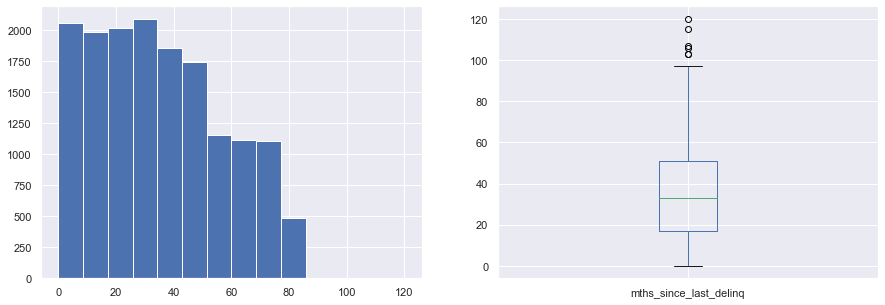

In [49]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
loan.mths_since_last_delinq.hist(bins=14)
plt.subplot(1,2,2)
loan.mths_since_last_delinq.plot.box()

In [50]:
loan.mths_since_last_delinq.describe()

count    15609.000000
mean        35.017618
std         22.418427
min          0.000000
25%         17.000000
50%         33.000000
75%         51.000000
max        120.000000
Name: mths_since_last_delinq, dtype: float64

In [51]:
((loan.groupby(['mths_since_last_delinq','loan_status']).count()['loan_amnt'])*100/(loan.groupby('mths_since_last_delinq').count()['loan_amnt'])).reset_index().pivot(index= 'mths_since_last_delinq',columns='loan_status')

loan_amnt            
loan_status            Charged Off  Fully Paid
mths_since_last_delinq                        
0.0                      24.847747   75.152253
1.0                      18.181818   81.818182
2.0                      18.260870   81.739130
3.0                      16.560510   83.439490
4.0                      16.463415   83.536585
...                            ...         ...
103.0                          NaN  100.000000
106.0                          NaN  100.000000
107.0                   100.000000         NaN
115.0                          NaN  100.000000
120.0                          NaN  100.000000

[95 rows x 2 columns]

<AxesSubplot:xlabel='mths_since_last_delinq', ylabel='Count'>

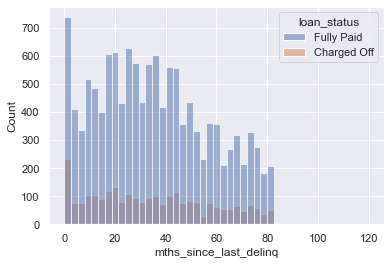

In [52]:
sns.histplot(data = loan, x='mths_since_last_delinq',hue='loan_status')

#### Zmienna przyjmuje wartości brakujące w ponad 60% obserwacji, a ponieważ nie wydaje się istotnie różnicować zmiennej objaśnianej, może być usunięta

In [53]:
loan.drop(columns='mths_since_last_delinq', inplace=True)

In [54]:
loan.revol_util.value_counts()

0%        1070
40.7%       65
0.2%        64
63%         63
66.6%       62
          ... 
24.89%       1
54.22%       1
9.71%        1
7.28%        1
24.63%       1
Name: revol_util, Length: 1119, dtype: int64

In [55]:
loan.revol_util = loan.revol_util.str.replace('%','').astype('float64')

In [56]:
loan.revol_util.value_counts(dropna=False)

0.00      1070
40.70       65
0.20        64
63.00       63
66.60       62
          ... 
33.26        1
106.20       1
100.50       1
11.63        1
52.58        1
Name: revol_util, Length: 1120, dtype: int64

<AxesSubplot:>

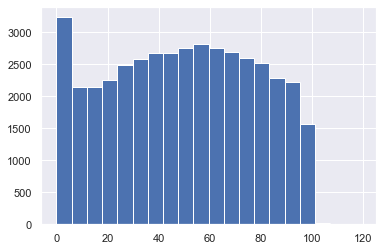

In [57]:
loan.revol_util.hist(bins=20)

In [58]:
loan.revol_util.describe()

count    42445.000000
mean        49.117156
std         28.364272
min          0.000000
25%         25.700000
50%         49.700000
75%         72.700000
max        119.000000
Name: revol_util, dtype: float64

<AxesSubplot:>

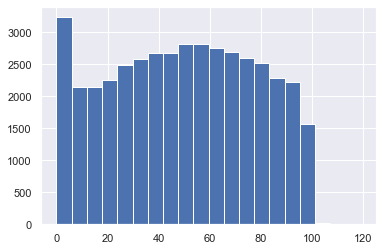

In [59]:
loan.revol_util.fillna(value=49).hist(bins=20)

In [60]:
# puste wartości zostaną zastąpione wartością zbliżoną do średniej jak i do mediany. Nie zmieni to rozkładu danych
loan.revol_util.fillna(value=49,inplace=True) 

In [61]:
loan.last_pymnt_d = pd.to_datetime(loan.last_pymnt_d)

<AxesSubplot:>

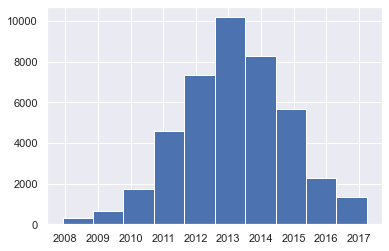

In [62]:
loan.last_pymnt_d.hist()

In [63]:
loan.issue_d = pd.to_datetime(loan.issue_d)

In [64]:
loan[['issue_d','last_pymnt_d']]

issue_d last_pymnt_d
0     2011-12-01   2015-01-01
1     2011-12-01   2013-04-01
2     2011-12-01   2014-06-01
3     2011-12-01   2015-01-01
4     2011-12-01   2017-01-01
...          ...          ...
42509 2007-07-01   2010-02-01
42511 2007-07-01   2010-08-01
42512 2007-07-01   2010-07-01
42513 2007-06-01   2010-06-01
42514 2007-06-01   2010-06-01

[42506 rows x 2 columns]

In [65]:
loan[loan.last_pymnt_d.isnull()]['last_pymnt_amnt'].value_counts()

0.0    83
Name: last_pymnt_amnt, dtype: int64

In [66]:
loan[loan.last_pymnt_d.isnull()]['total_pymnt'].value_counts()

0.00        19
90.00        6
180.00       4
45.00        3
900.00       3
360.00       2
450.00       2
432.00       2
108.00       2
1125.00      2
0.75         1
207.00       1
1017.00      1
468.00       1
135.00       1
216.00       1
325.00       1
270.00       1
741.65       1
359.77       1
315.00       1
63.00        1
1800.00      1
112.50       1
67.50        1
4494.43      1
200.00       1
1244.58      1
5037.98      1
0.80         1
607.50       1
1719.57      1
366.75       1
12325.00     1
182.61       1
86.05        1
282.88       1
1080.00      1
346.50       1
189.00       1
61.88        1
225.00       1
540.00       1
81.00        1
410.00       1
162.00       1
213.75       1
1980.00      1
Name: total_pymnt, dtype: int64

#### Założenie jest, że puste wartości w last_pymnt_d oznaczają, że ostatniej płatności nie było wcale. Wskazują na to zerowe wartości zmiennej 'last_pymnt_amnt'. Jednak zmienna 'total_pymnt' tylko w części tych przypadków przyjmuje wartość 0, potwierdzając poprawność założenia o braku płatności kiedykolwiek. W przypadkach gdzie 'total_pymnt' jest niezerowe, wartości puste należy uzupełnić średnią. By móc wypełnić te puste wartości - w pierwszej kolejności należy zamienić konkretną datę na wartość, w tym przypadku liczba dni od otrzymania kredytu do dni ostatniej płatności. 

In [67]:
loan['last_pymnt_days_after_issue'] = loan.last_pymnt_d - loan.issue_d

In [68]:
loan['last_pymnt_days_after_issue'].describe()

count                          42423
mean     886 days 08:16:35.912588192
std      436 days 17:37:39.671901720
min                 28 days 00:00:00
25%                549 days 00:00:00
50%                974 days 00:00:00
75%               1126 days 00:00:00
max               2130 days 00:00:00
Name: last_pymnt_days_after_issue, dtype: object

#### Puste wartości zostają zastąpione wartością 0 days oznaczjaące, że nie dokonano żadnej płatności, a wartością średnią w przeciwnym przypadku

In [69]:
loan.last_pymnt_days_after_issue.loc[loan.total_pymnt==0] = '0 days'

C:\Users\morze\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [70]:
loan.last_pymnt_days_after_issue.fillna(value='886 days',inplace=True)

In [71]:
loan['last_pymnt_days_after_issue'] = loan['last_pymnt_days_after_issue'].astype('str').str.replace('days 00:00:00','').str.replace('days','').astype('int64')
loan['last_pymnt_days_after_issue']

0        1127
1         487
2         913
3        1127
4        1858
         ... 
42509     946
42511    1127
42512    1096
42513    1096
42514    1096
Name: last_pymnt_days_after_issue, Length: 42506, dtype: int64

In [72]:
loan.drop(columns='last_pymnt_d',inplace=True) #zmienną z datą można usunąc - informacje z niej są w nowej zmiennej

In [73]:
loan[loan.last_credit_pull_d.isnull()].index #tylko trzy obserwacje z pustymi wartościami - mozna je usunąć 

Int64Index([26094, 39545, 42483], dtype='int64')

In [74]:
loan.drop(index=loan[loan.last_credit_pull_d.isnull()].index, inplace=True)

In [75]:
loan.collections_12_mths_ex_med.value_counts() # zmienna przyjmuje tylko jedną wartość, nie wnosi informacji

0.0    42388
Name: collections_12_mths_ex_med, dtype: int64

In [76]:
loan.drop(columns='collections_12_mths_ex_med',inplace=True)

In [77]:
loan.chargeoff_within_12_mths.value_counts() # zmienna przyjmuje tylko jedną wartość, nie wnosi informacji

0.0    42388
Name: chargeoff_within_12_mths, dtype: int64

In [78]:
loan.drop(columns='chargeoff_within_12_mths', inplace=True)

In [79]:
loan.pub_rec_bankruptcies.value_counts()

0.0    39315
1.0     1846
2.0        8
Name: pub_rec_bankruptcies, dtype: int64

In [80]:
loan.pub_rec_bankruptcies.fillna(value=0.0,inplace=True)

In [81]:
loan.tax_liens.value_counts() #zmienna przyjmuje praktycznie jedną wartość, nie wnosi informacji

0.0    42427
1.0        1
Name: tax_liens, dtype: int64

In [82]:
loan.drop(columns='tax_liens',inplace=True)

In [83]:
loan.isnull().sum().sum()

0

Dane są oczyszczone z pustych wartości

<a id='eda'></a>
## EDA 

In [84]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42503 entries, 0 to 42514
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   loan_amnt                    42503 non-null  float64       
 1   funded_amnt                  42503 non-null  float64       
 2   funded_amnt_inv              42503 non-null  float64       
 3   term                         42503 non-null  object        
 4   int_rate                     42503 non-null  object        
 5   installment                  42503 non-null  float64       
 6   grade                        42503 non-null  object        
 7   sub_grade                    42503 non-null  object        
 8   emp_length                   42503 non-null  object        
 9   home_ownership               42503 non-null  object        
 10  annual_inc                   42503 non-null  float64       
 11  verification_status          42503 non-nu

In [85]:
for x in loan.columns:
    print(x)
    print(f'\t Maksymalna częstość wystąpienia zmiennej: {max(loan[x].value_counts())}')
    print(f'\t Minimalna częstość wystąpienia zmiennej: {min(loan[x].value_counts())}')

loan_amnt
	 Maksymalna częstość wystąpienia zmiennej: 3016
	 Minimalna częstość wystąpienia zmiennej: 1
funded_amnt
	 Maksymalna częstość wystąpienia zmiennej: 2924
	 Minimalna częstość wystąpienia zmiennej: 1
funded_amnt_inv
	 Maksymalna częstość wystąpienia zmiennej: 1368
	 Minimalna częstość wystąpienia zmiennej: 1
term
	 Maksymalna częstość wystąpienia zmiennej: 31502
	 Minimalna częstość wystąpienia zmiennej: 11001
int_rate
	 Maksymalna częstość wystąpienia zmiennej: 970
	 Minimalna częstość wystąpienia zmiennej: 1
installment
	 Maksymalna częstość wystąpienia zmiennej: 68
	 Minimalna częstość wystąpienia zmiennej: 1
grade
	 Maksymalna częstość wystąpienia zmiennej: 12378
	 Minimalna częstość wystąpienia zmiennej: 512
sub_grade
	 Maksymalna częstość wystąpienia zmiennej: 2993
	 Minimalna częstość wystąpienia zmiennej: 79
emp_length
	 Maksymalna częstość wystąpienia zmiennej: 10052
	 Minimalna częstość wystąpienia zmiennej: 1340
home_ownership
	 Maksymalna częstość wystąpienia zmie

#### Usunięcie zmiennych, które przyjmują tylko jedną wartość bądź wszystkie różne wartości (w przypadku zmiennych kategorycznych)

In [86]:
loan.drop(columns='url',inplace=True)

In [87]:
loan.drop(columns='pymnt_plan',inplace=True)

In [88]:
loan.initial_list_status.value_counts()

f    42503
Name: initial_list_status, dtype: int64

In [89]:
loan.drop(columns='initial_list_status', inplace=True)

In [90]:
loan.disbursement_method.value_counts()

Cash    42503
Name: disbursement_method, dtype: int64

In [91]:
loan.drop(columns=['out_prncp','out_prncp_inv','policy_code','application_type','acc_now_delinq','delinq_amnt','hardship_flag','disbursement_method'], inplace=True)

In [92]:
loan.groupby(['recoveries','loan_status']).count()['loan_amnt'].reset_index().pivot(index='recoveries',columns='loan_status')

loan_amnt           
loan_status Charged Off Fully Paid
recoveries                        
0.00               72.0    36076.0
0.01                7.0        NaN
0.02                3.0        NaN
0.03                4.0        NaN
0.04                6.0        NaN
...                 ...        ...
21811.73            1.0        NaN
22943.37            1.0        NaN
27009.47            1.0        NaN
27750.00            1.0        NaN
29623.35            1.0        NaN

[5054 rows x 2 columns]

In [93]:
loan.groupby(['collection_recovery_fee','loan_status']).count()['loan_amnt'].reset_index().pivot(index='collection_recovery_fee',columns='loan_status')

loan_amnt           
loan_status             Charged Off Fully Paid
collection_recovery_fee                       
0.0000                       2103.0    36076.0
0.0450                          1.0        NaN
0.0630                          1.0        NaN
0.0745                          1.0        NaN
0.1181                          1.0        NaN
...                             ...        ...
5602.7200                       1.0        NaN
5774.8000                       1.0        NaN
6543.0400                       1.0        NaN
6972.5900                       1.0        NaN
7002.1900                       1.0        NaN

[2895 rows x 2 columns]

Zmienne dotyczące windykacji długu (recoveries, colletion_recovery_fee) mają miejsce po fakcie odpisania długu, więc nie mają zdolności predycyjnej zdarzenia spłaty bądź kredytu, więc mogą być usunięte

In [94]:
loan.drop(columns=['recoveries','collection_recovery_fee'],inplace=True)

<a id='feature'></a>
### Feature engineering - zmiana typów, tworzenie nowych zmiennych

In [95]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42503 entries, 0 to 42514
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   loan_amnt                    42503 non-null  float64       
 1   funded_amnt                  42503 non-null  float64       
 2   funded_amnt_inv              42503 non-null  float64       
 3   term                         42503 non-null  object        
 4   int_rate                     42503 non-null  object        
 5   installment                  42503 non-null  float64       
 6   grade                        42503 non-null  object        
 7   sub_grade                    42503 non-null  object        
 8   emp_length                   42503 non-null  object        
 9   home_ownership               42503 non-null  object        
 10  annual_inc                   42503 non-null  float64       
 11  verification_status          42503 non-nu

In [96]:
loan.int_rate = loan.int_rate.str.replace('%','').astype('float64')

In [97]:
loan.earliest_cr_line = pd.to_datetime(loan.earliest_cr_line)

### Zamiana dat na wartości

Zmienne datowe są słabym predyktorem (w przypadku innym niż szeregi czasowe), bo żadna data się nigdy nie powtórzy, a wartości w oparciu o daty już tak 

In [98]:
loan['credit_age_days'] = loan.issue_d - loan.earliest_cr_line

In [99]:
loan['credit_age_days'] = loan['credit_age_days'].astype('str').str.replace('days','').astype('int64')

Zmienna wiek kredytowy (data wnioskowania o obecny kredyt minus data otwarcia lini kredytowej)

In [100]:
loan.last_credit_pull_d = pd.to_datetime(loan.last_credit_pull_d)

In [101]:
loan[['issue_d','last_credit_pull_d']]

issue_d last_credit_pull_d
0     2011-12-01         2018-08-01
1     2011-12-01         2016-10-01
2     2011-12-01         2017-06-01
3     2011-12-01         2016-04-01
4     2011-12-01         2018-04-01
...          ...                ...
42509 2007-07-01         2013-07-01
42511 2007-07-01         2010-08-01
42512 2007-07-01         2010-06-01
42513 2007-06-01         2014-10-01
42514 2007-06-01         2018-05-01

[42503 rows x 2 columns]

In [102]:
loan['days_from_issue_to_last_cred_pull'] = loan.last_credit_pull_d - loan.issue_d

In [103]:
loan['days_from_issue_to_last_cred_pull'] = loan['days_from_issue_to_last_cred_pull'].astype('str').str.replace('days','').astype('int64')

In [104]:
loan.drop(columns=['last_credit_pull_d','issue_d','earliest_cr_line'],inplace=True)

In [105]:
fico_cols = loan.columns[loan.columns.str.contains('fico')]

In [106]:
loan[fico_cols]

fico_range_low  fico_range_high  last_fico_range_high  \
0               735.0            739.0                 739.0   
1               740.0            744.0                 499.0   
2               735.0            739.0                 739.0   
3               690.0            694.0                 604.0   
4               695.0            699.0                 684.0   
...               ...              ...                   ...   
42509           660.0            664.0                 704.0   
42511           650.0            654.0                 499.0   
42512           800.0            804.0                 809.0   
42513           695.0            699.0                 769.0   
42514           695.0            699.0                 549.0   

       last_fico_range_low  
0                    735.0  
1                      0.0  
2                    735.0  
3                    600.0  
4                    680.0  
...                    ...  
42509                700.0  
42511                  0.0  
42512                805.0  
42513                765.0  
42514                545.0  

[42503 rows x 4 columns]

In [107]:
loan[fico_cols].describe()

fico_range_low  fico_range_high  last_fico_range_high  \
count    42503.000000     42503.000000          42503.000000   
mean       713.044256       717.044256            689.981107   
std         36.180426        36.180426             80.542863   
min        610.000000       614.000000              0.000000   
25%        685.000000       689.000000            644.000000   
50%        710.000000       714.000000            699.000000   
75%        740.000000       744.000000            749.000000   
max        825.000000       829.000000            850.000000   

       last_fico_range_low  
count         42503.000000  
mean            677.003506  
std             119.492826  
min               0.000000  
25%             640.000000  
50%             695.000000  
75%             745.000000  
max             845.000000

In [108]:
loan['avg_fico'] = loan[fico_cols[:2]].mean(axis=1)

In [109]:
loan['avg_last_fico'] = loan[fico_cols[2:]].mean(axis=1)

In [110]:
loan.drop(columns=fico_cols, inplace=True)

In [111]:
loan['fico_diff'] = loan['avg_last_fico'] - loan['avg_fico']

In [112]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42503 entries, 0 to 42514
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   loan_amnt                          42503 non-null  float64
 1   funded_amnt                        42503 non-null  float64
 2   funded_amnt_inv                    42503 non-null  float64
 3   term                               42503 non-null  object 
 4   int_rate                           42503 non-null  float64
 5   installment                        42503 non-null  float64
 6   grade                              42503 non-null  object 
 7   sub_grade                          42503 non-null  object 
 8   emp_length                         42503 non-null  object 
 9   home_ownership                     42503 non-null  object 
 10  annual_inc                         42503 non-null  float64
 11  verification_status                42503 non-null  obj

In [113]:
col_num=[]
col_cat=[]

for c in loan.columns:
    if loan.dtypes[c]=='object':
        col_cat.append(c)
    else:
        col_num.append(c)

In [114]:
round(loan[col_num].describe(),2)

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
count   42503.00     42503.00         42503.00  42503.00     42503.00   
mean    11095.17     10826.88         10146.83     12.17       322.77   
std      7410.80      7146.74          7129.73      3.71       208.92   
min       500.00       500.00             0.00      5.42        15.67   
25%      5200.00      5025.00          4950.00      9.63       165.67   
50%      9750.00      9600.00          8500.00     11.99       277.87   
75%     15000.00     15000.00         14000.00     14.72       428.50   
max     35000.00     35000.00         35000.00     24.59      1305.19   

       annual_inc       dti  delinq_2yrs  inq_last_6mths  open_acc  ...  \
count    42503.00  42503.00     42503.00        42503.00  42503.00  ...   
mean     69133.97     13.38         0.15            1.08      9.34  ...   
std      64097.62      6.73         0.51            1.53      4.50  ...   
min       1896.00      0.00         0.00            0.00      1.00  ...   
25%      40000.00      8.20         0.00            0.00      6.00  ...   
50%      59000.00     13.48         0.00            1.00      9.00  ...   
75%      82430.00     18.69         0.00            2.00     12.00  ...   
max    6000000.00     29.99        13.00           33.00     47.00  ...   

       total_rec_int  total_rec_late_fee  last_pymnt_amnt  \
count       42503.00            42503.00         42503.00   
mean         2241.32                1.51          2615.00   
std          2585.56                7.81          4386.22   
min             0.00                0.00             0.00   
25%           657.90                0.00           211.46   
50%          1340.26                0.00           528.99   
75%          2804.20                0.00          3172.32   
max         23886.47              209.00         36115.20   

       pub_rec_bankruptcies  last_pymnt_days_after_issue  credit_age_days  \
count              42503.00                     42503.00         42503.00   
mean                   0.04                       885.96          4993.38   
std                    0.21                       436.72          2516.13   
min                    0.00                         0.00           184.00   
25%                    0.00                       549.00          3287.00   
50%                    0.00                       974.00          4564.00   
75%                    0.00                      1126.00          6209.00   
max                    2.00                      2130.00         23892.00   

       days_from_issue_to_last_cred_pull  avg_fico  avg_last_fico  fico_diff  
count                           42503.00  42503.00       42503.00   42503.00  
mean                             1963.56    715.04         683.49     -31.55  
std                               865.24     36.18          96.39      91.11  
min                              -884.00    612.00           0.00    -782.00  
25%                              1127.00    687.00         642.00     -70.00  
50%                              2100.00    712.00         697.00     -15.00  
75%                              2618.00    742.00         747.00      25.00  
max                              4049.00    827.00         847.50     185.00  

[8 rows x 27 columns]

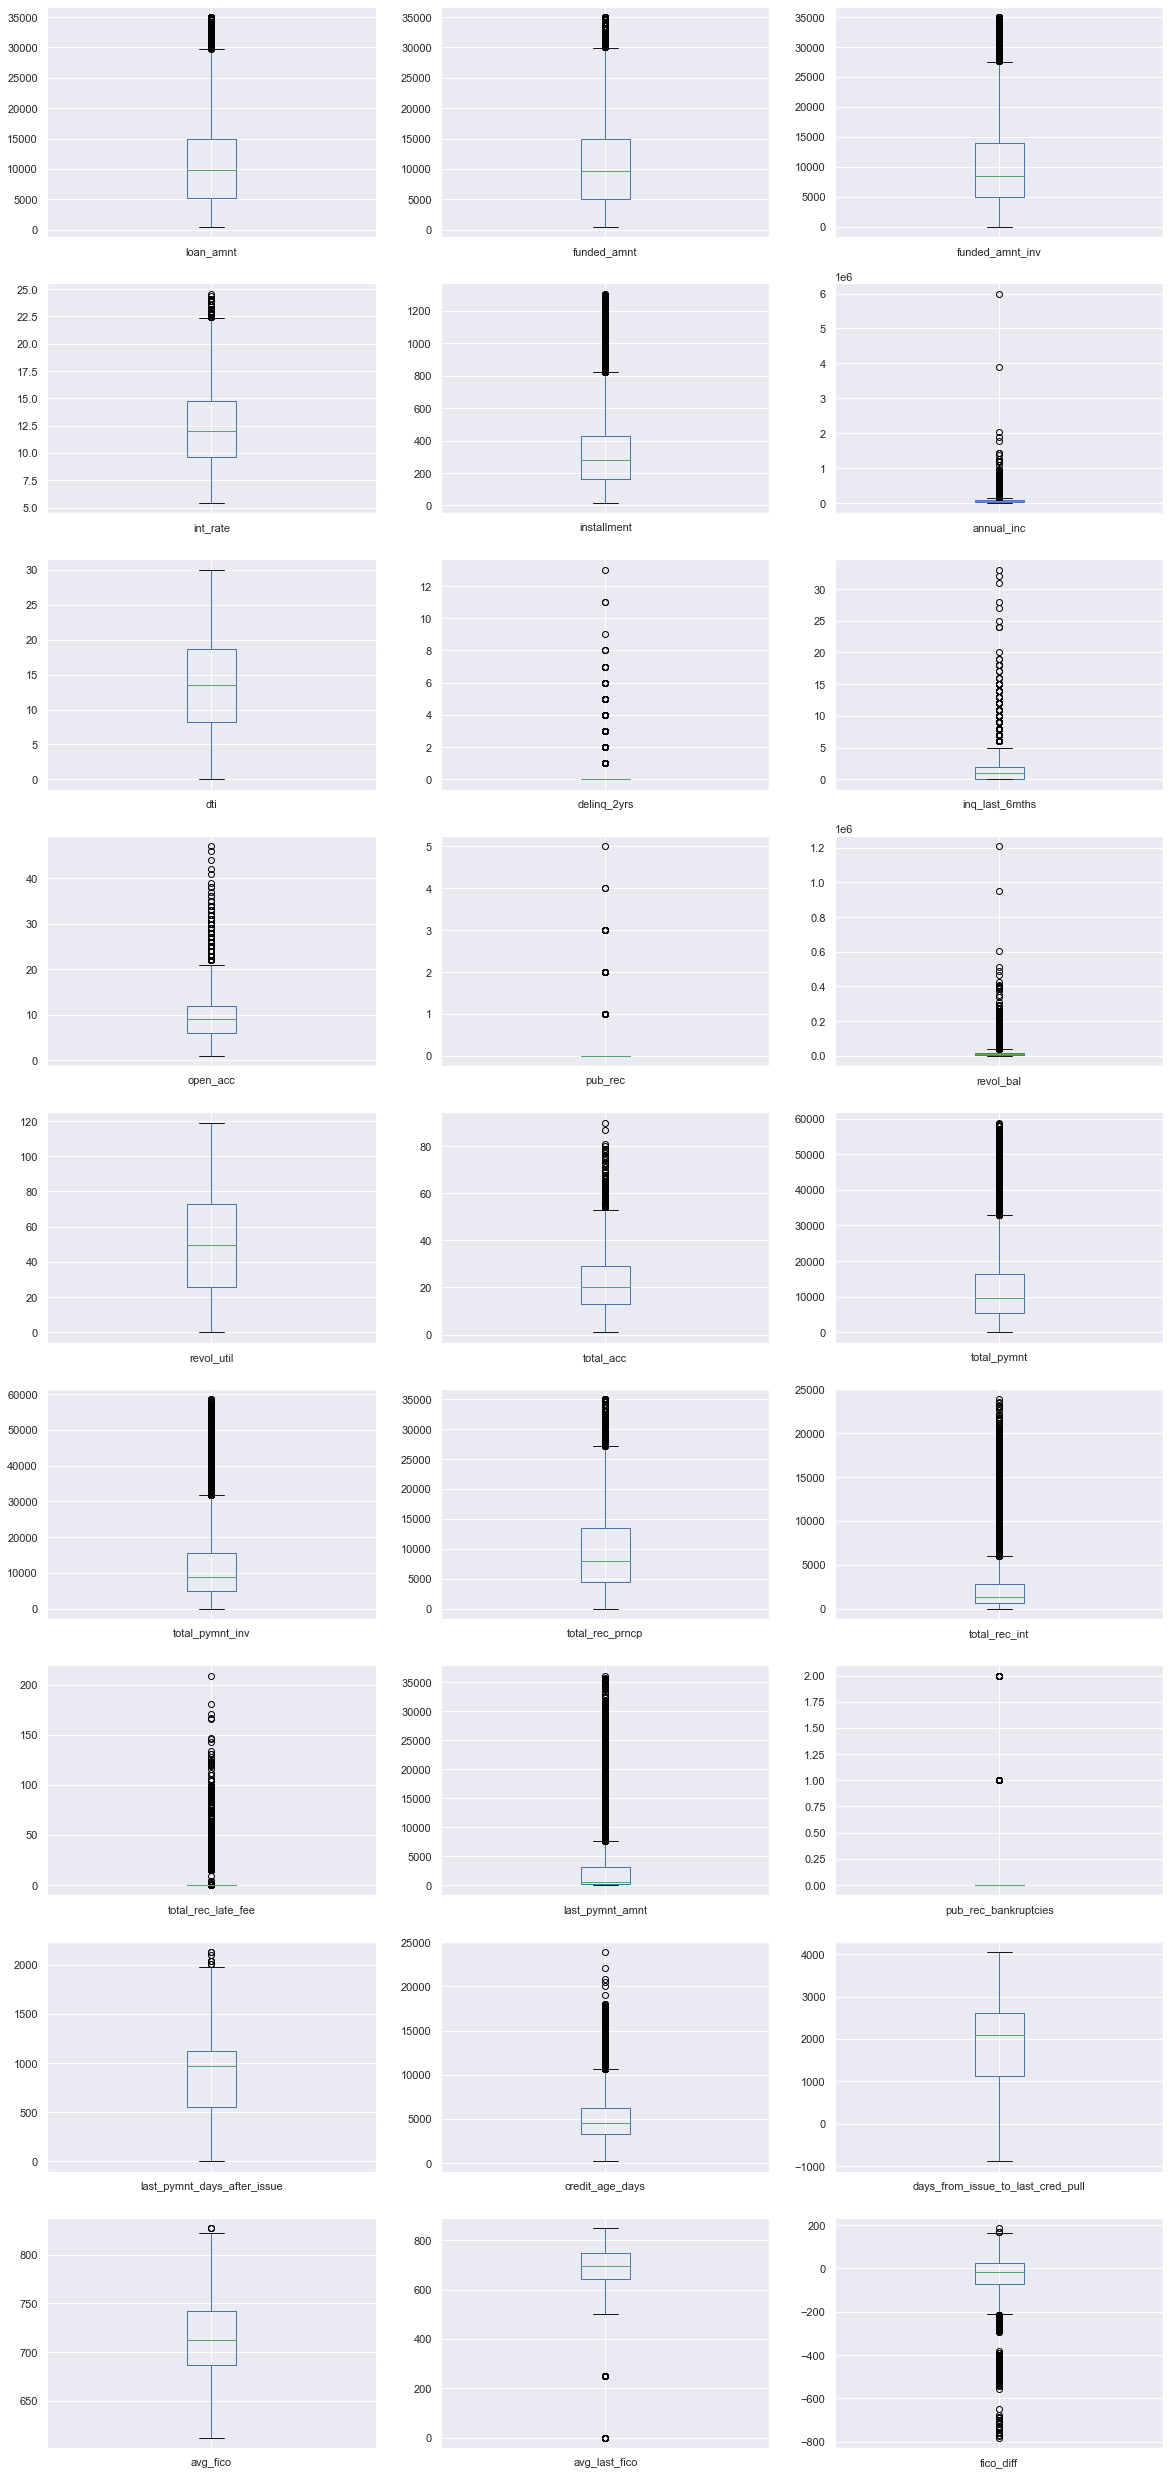

In [115]:
plt.figure(figsize=(20,50))
for i,c in enumerate(col_num):
    plt.subplot(10,3,i+1)
    loan[c].plot.box()

#### Duża część zmiennych numerycznych ma niesymetryczny rozkład, gdzie obserwacje kumulują się w dolnych wartościach zmiennych, a obserwacje przyjmujące wyższe wartości są raczej unikalne

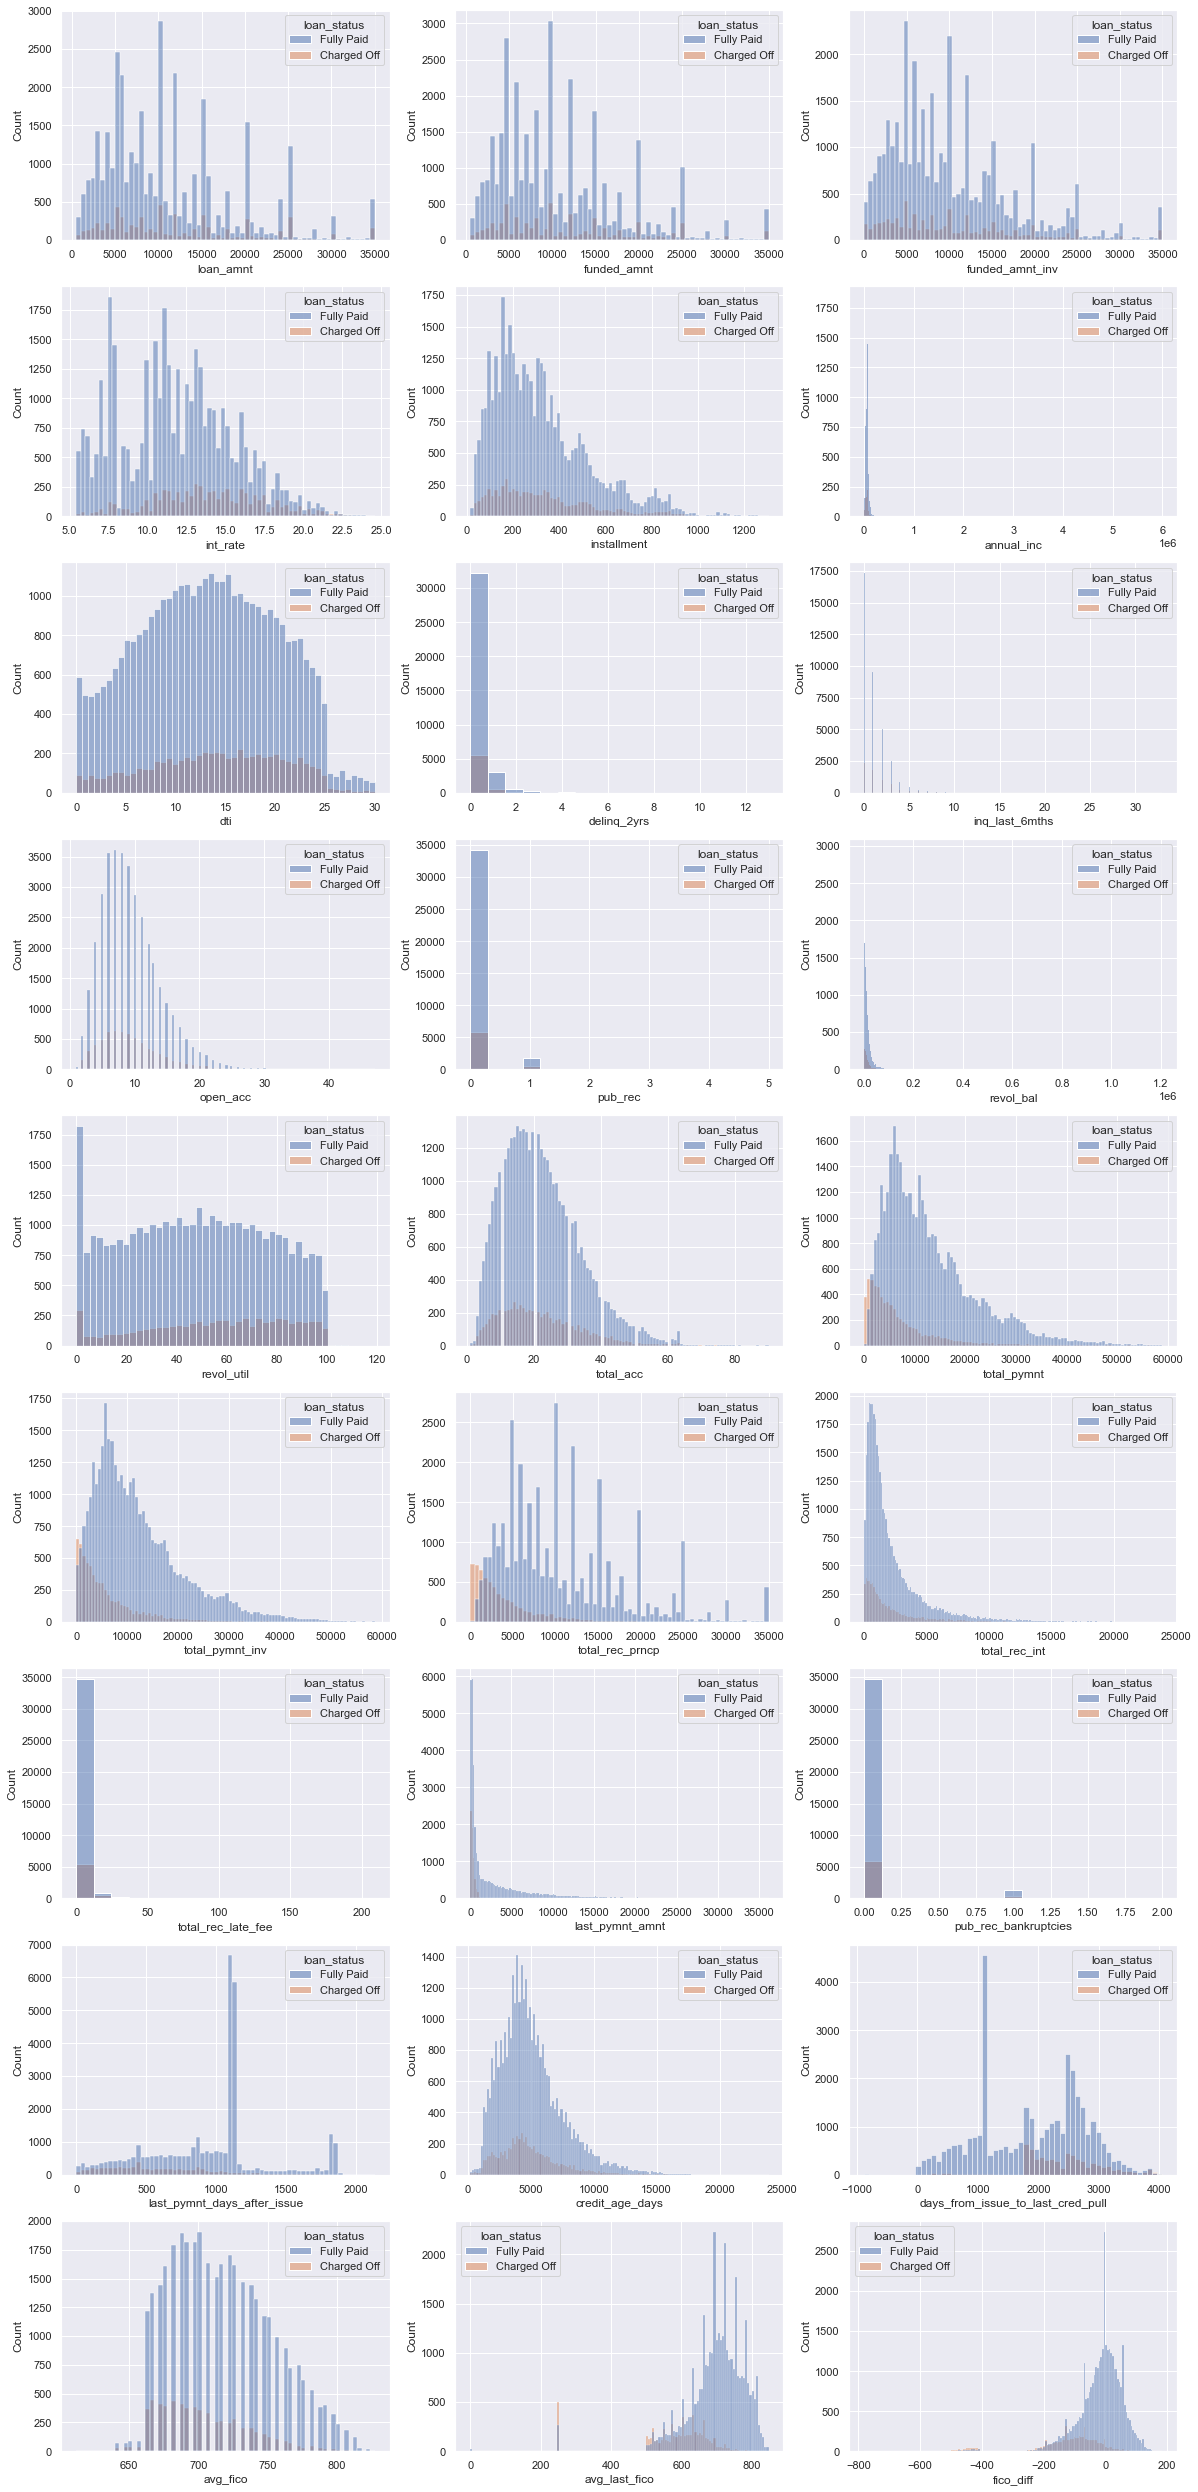

In [116]:
plt.figure(figsize=(20,50))
for i,c in enumerate(col_num):
    plt.subplot(10,3,i+1)
    sns.histplot(data = loan, x=c, hue='loan_status')

In [117]:
num_to_cat = ['delinq_2yrs', 'inq_last_6mths', 'pub_rec','pub_rec_bankruptcies']

Patrząc na rozkłady tych zmiennych wydaje się, że mają one bardziej charakter zmiennej kategorycznej niż numerycznej

In [118]:
num_to_cat

['delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'pub_rec_bankruptcies']

In [119]:
for x in num_to_cat:
    col_num.remove(x)

In [120]:
loan.delinq_2yrs = loan.delinq_2yrs.astype('int64')
loan.inq_last_6mths = loan.inq_last_6mths.astype('int64')
loan.pub_rec = loan.pub_rec.astype('int64')
loan.pub_rec_bankruptcies = loan.pub_rec_bankruptcies.astype('int64')

In [121]:
loan.total_rec_late_fee.value_counts()

0.000000     40117
15.000000       69
30.000000        8
45.000000        3
28.760000        2
             ...  
15.000000        1
15.000000        1
16.980000        1
24.112682        1
15.000000        1
Name: total_rec_late_fee, Length: 2295, dtype: int64

Ze względu na bardzo duży udział jednej wartości i długi ogon pozostałych, zmienną warto jest zamienić na kategoryczną

In [122]:
loan.total_rec_late_fee[loan.total_rec_late_fee>0].value_counts(bins=4, sort=False)

(-0.2, 52.258]        2184
(52.258, 104.505]      174
(104.505, 156.753]      23
(156.753, 209.0]         5
Name: total_rec_late_fee, dtype: int64

In [123]:
loan.loc[loan.total_rec_late_fee==0,'late_fee_range']=0
loan.loc[(loan.total_rec_late_fee>0)&(loan.total_rec_late_fee<=53),'late_fee_range']=1
loan.loc[(loan.total_rec_late_fee>53)&(loan.total_rec_late_fee<=105),'late_fee_range']=2
loan.loc[(loan.total_rec_late_fee>105)&(loan.total_rec_late_fee<=157),'late_fee_range']=3
loan.loc[loan.total_rec_late_fee>157,'late_fee_range']=4

In [124]:
loan.late_fee_range.value_counts()

0.0    40117
1.0     2189
2.0      172
3.0       20
4.0        5
Name: late_fee_range, dtype: int64

In [125]:
loan.late_fee_range = loan.late_fee_range.astype('int64')

In [126]:
col_num.remove('total_rec_late_fee')

In [127]:
col_cat.append('late_fee_range')

<a id='outlier'></a>
### Analiza wartości odstających

In [128]:
round(loan[col_num].describe())

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
count    42503.0      42503.0          42503.0   42503.0      42503.0   
mean     11095.0      10827.0          10147.0      12.0        323.0   
std       7411.0       7147.0           7130.0       4.0        209.0   
min        500.0        500.0              0.0       5.0         16.0   
25%       5200.0       5025.0           4950.0      10.0        166.0   
50%       9750.0       9600.0           8500.0      12.0        278.0   
75%      15000.0      15000.0          14000.0      15.0        428.0   
max      35000.0      35000.0          35000.0      25.0       1305.0   

       annual_inc      dti  open_acc  revol_bal  revol_util  ...  \
count     42503.0  42503.0   42503.0    42503.0     42503.0  ...   
mean      69134.0     13.0       9.0    14308.0        49.0  ...   
std       64098.0      7.0       4.0    22023.0        28.0  ...   
min        1896.0      0.0       1.0        0.0         0.0  ...   
25%       40000.0      8.0       6.0     3646.0        26.0  ...   
50%       59000.0     13.0       9.0     8831.0        50.0  ...   
75%       82430.0     19.0      12.0    17258.0        73.0  ...   
max     6000000.0     30.0      47.0  1207359.0       119.0  ...   

       total_pymnt_inv  total_rec_prncp  total_rec_int  last_pymnt_amnt  \
count          42503.0          42503.0        42503.0          42503.0   
mean           11320.0           9680.0         2241.0           2615.0   
std             9037.0           7106.0         2586.0           4386.0   
min                0.0              0.0            0.0              0.0   
25%             4804.0           4402.0          658.0            211.0   
50%             8960.0           8000.0         1340.0            529.0   
75%            15548.0          13500.0         2804.0           3172.0   
max            58564.0          35000.0        23886.0          36115.0   

       last_pymnt_days_after_issue  credit_age_days  \
count                      42503.0          42503.0   
mean                         886.0           4993.0   
std                          437.0           2516.0   
min                            0.0            184.0   
25%                          549.0           3287.0   
50%                          974.0           4564.0   
75%                         1126.0           6209.0   
max                         2130.0          23892.0   

       days_from_issue_to_last_cred_pull  avg_fico  avg_last_fico  fico_diff  
count                            42503.0   42503.0        42503.0    42503.0  
mean                              1964.0     715.0          683.0      -32.0  
std                                865.0      36.0           96.0       91.0  
min                               -884.0     612.0            0.0     -782.0  
25%                               1127.0     687.0          642.0      -70.0  
50%                               2100.0     712.0          697.0      -15.0  
75%                               2618.0     742.0          747.0       25.0  
max                               4049.0     827.0          848.0      185.0  

[8 rows x 22 columns]

In [129]:
for c in col_num:
    Q1 = loan[c].quantile(q=0.25)
    Q3 = loan[c].quantile(q=0.75)
    IQR = stats.iqr(loan[c])
    low_out_border = Q1-1.5*IQR
    up_out_border = Q3+1.5*IQR
    bottom_out = loan[loan[c]<low_out_border][c].count()*100/loan[c].count()
    top_out = loan[loan[c]>up_out_border][c].count()*100/loan[c].count()
    print(c)
    print(f'\t Udział wartości odstających: {round(bottom_out+top_out,2)}%')

loan_amnt
	 Udział wartości odstających: 2.87%
funded_amnt
	 Udział wartości odstających: 2.41%
funded_amnt_inv
	 Udział wartości odstających: 2.72%
int_rate
	 Udział wartości odstających: 0.22%
installment
	 Udział wartości odstających: 3.28%
annual_inc
	 Udział wartości odstających: 4.77%
dti
	 Udział wartości odstających: 0.0%
open_acc
	 Udział wartości odstających: 1.46%
revol_bal
	 Udział wartości odstających: 6.84%
revol_util
	 Udział wartości odstających: 0.0%
total_acc
	 Udział wartości odstających: 1.42%
total_pymnt
	 Udział wartości odstających: 3.38%
total_pymnt_inv
	 Udział wartości odstających: 3.65%
total_rec_prncp
	 Udział wartości odstających: 2.43%
total_rec_int
	 Udział wartości odstających: 7.9%
last_pymnt_amnt
	 Udział wartości odstających: 10.97%
last_pymnt_days_after_issue
	 Udział wartości odstających: 0.02%
credit_age_days
	 Udział wartości odstających: 3.38%
days_from_issue_to_last_cred_pull
	 Udział wartości odstających: 0.0%
avg_fico
	 Udział wartości odstają

In [130]:
out_rows = []
for c in col_num:
    Q1 = loan[c].quantile(q=0.25)
    Q3 = loan[c].quantile(q=0.75)
    IQR = stats.iqr(loan[c])
    low_out_border = Q1-1.5*IQR
    up_out_border = Q3+1.5*IQR
    out_rows += list(loan[(loan[c]<low_out_border)|(loan[c]>up_out_border)].index)

In [131]:
len(set(out_rows))/loan.shape[0] ## udział wartości odstających w danych

0.30230807237136204

In [132]:
loan.drop(index=set(out_rows), inplace=True)

<a id='corr'></a>
## Analiza zależności

In [133]:
loan = pd.get_dummies(loan,columns=['loan_status'])
loan.head()

loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  installment  \
0     5000.0       5000.0           4975.0   36 months     10.65       162.87   
2     2400.0       2400.0           2400.0   36 months     15.96        84.33   
3    10000.0      10000.0          10000.0   36 months     13.49       339.31   
4     3000.0       3000.0           3000.0   60 months     12.69        67.79   
5     5000.0       5000.0           5000.0   36 months      7.90       156.46   

  grade sub_grade emp_length home_ownership  ...  debt_settlement_flag  \
0     B        B2  10+ years           RENT  ...                     N   
2     C        C5  10+ years           RENT  ...                     N   
3     C        C1  10+ years           RENT  ...                     N   
4     B        B5     1 year           RENT  ...                     N   
5     A        A4    3 years           RENT  ...                     N   

  last_pymnt_days_after_issue credit_age_days  \
0                        1127            9830   
2                         913            3682   
3                        1127            5782   
4                        1858            5813   
5                        1127            2586   

  days_from_issue_to_last_cred_pull avg_fico  avg_last_fico  fico_diff  \
0                              2435    737.0          737.0        0.0   
2                              2009    737.0          737.0        0.0   
3                              1583    692.0          602.0      -90.0   
4                              2313    697.0          682.0      -15.0   
5                              1889    732.0          562.0     -170.0   

   late_fee_range  loan_status_Charged Off  loan_status_Fully Paid  
0               0                        0                       1  
2               0                        0                       1  
3               1                        0                       1  
4               0                        0                       1  
5               0                        0                       1  

[5 rows x 40 columns]

In [134]:
loan.rename(columns={'loan_status_Charged Off': 'if_charged_off','loan_status_Fully Paid':'if_fully_paid'},inplace=True)

In [135]:
col_num.append('if_charged_off')

<AxesSubplot:>

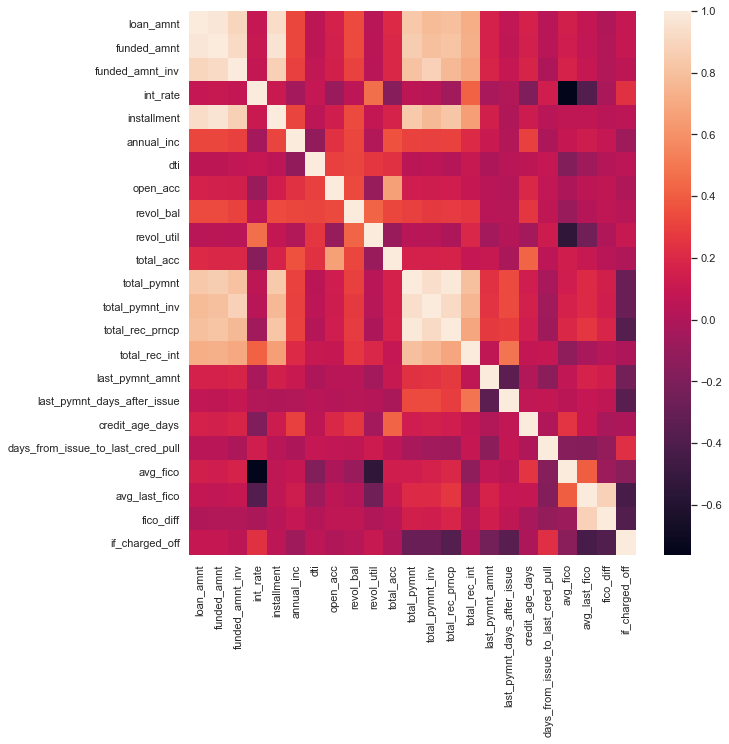

In [136]:
plt.figure(figsize=(10,10))
sns.heatmap(loan[col_num].corr())

In [137]:
loan[col_num].corr()['if_charged_off'].sort_values()

avg_last_fico                       -0.430575
fico_diff                           -0.388890
total_rec_prncp                     -0.371850
last_pymnt_days_after_issue         -0.353635
total_pymnt                         -0.283866
total_pymnt_inv                     -0.280905
last_pymnt_amnt                     -0.242298
avg_fico                            -0.155470
annual_inc                          -0.061550
total_rec_int                       -0.010224
credit_age_days                     -0.007569
total_acc                            0.001544
open_acc                             0.006981
revol_bal                            0.031024
installment                          0.055907
dti                                  0.057591
funded_amnt_inv                      0.058623
funded_amnt                          0.093671
loan_amnt                            0.096831
revol_util                           0.102043
days_from_issue_to_last_cred_pull    0.230069
int_rate                          

### Wśród zmmiennych numerycznych najsilniej skorelowane wydają się być zmienne dotyczące scoringu FICO (avg_last_fico, fico_diff) dotychczasowej spłaty kapitału (total_rec_prncp) oraz ostatatniej płatności (last_pymnt_days_after_issue)

In [138]:
col_cat.remove('loan_status')

In [139]:
col_cat

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'zip_code',
 'addr_state',
 'debt_settlement_flag',
 'late_fee_range']

In [140]:
for x in num_to_cat:
    col_cat.append(x)

In [141]:
col_cat

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'zip_code',
 'addr_state',
 'debt_settlement_flag',
 'late_fee_range',
 'delinq_2yrs',
 'inq_last_6mths',
 'pub_rec',
 'pub_rec_bankruptcies']

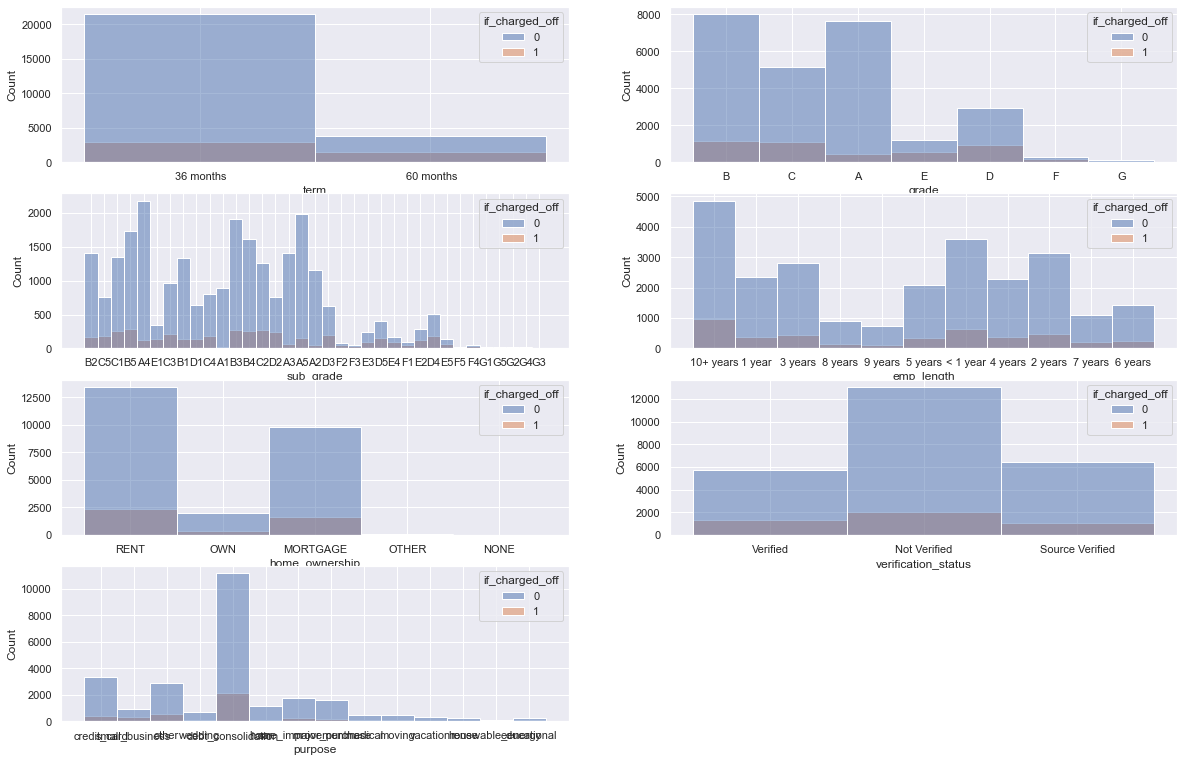

In [142]:
plt.figure(figsize=(20,20))
for i,c in enumerate(col_cat[:7]):
    plt.subplot(6,2,i+1)
    sns.histplot(data = loan, x=c, hue='if_charged_off')

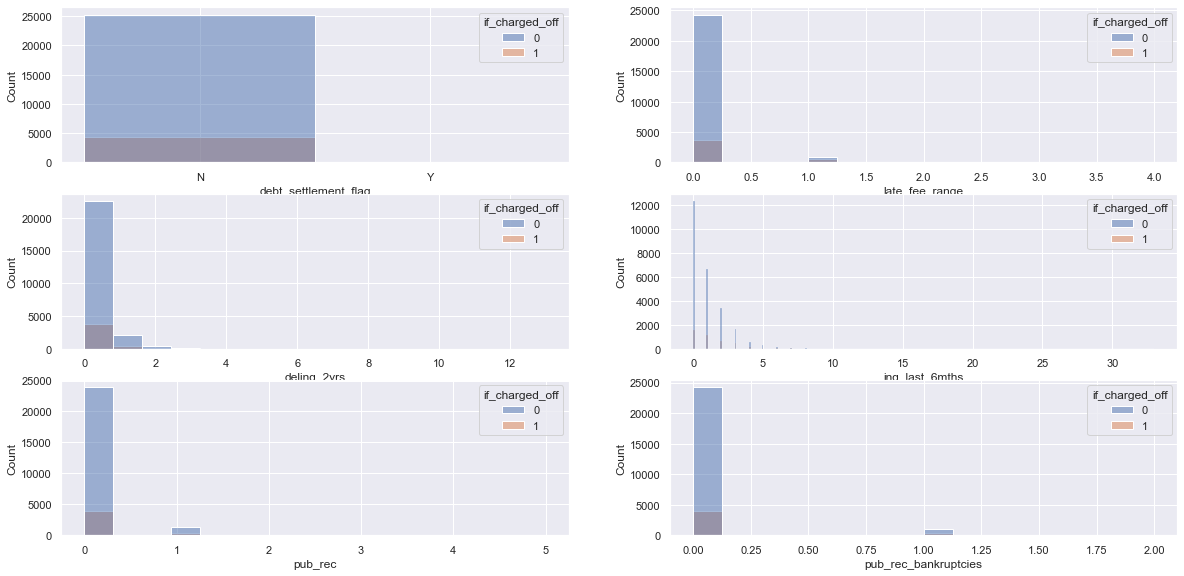

In [143]:
plt.figure(figsize=(20,20))
for i,c in enumerate(col_cat[9:]):
    plt.subplot(6,2,i+1)
    sns.histplot(data = loan, x=c, hue='if_charged_off')

In [144]:
(loan.groupby('if_charged_off').count()['loan_amnt'])*100/loan.if_charged_off.count()

if_charged_off
0    85.21616
1    14.78384
Name: loan_amnt, dtype: float64

In [145]:
for c in col_cat:
    freq = ((loan.groupby([c,'if_charged_off']).count()['loan_amnt'])*100/(loan.groupby([c]).count()['loan_amnt'])).reset_index().rename(mapper={'loan_amnt':'frequencies'}, axis=1)
    pivot = pd.pivot_table(freq,index=c,columns='if_charged_off')
    print(pivot)

               frequencies           
if_charged_off           0          1
term                                 
 36 months       88.271554  11.728446
 60 months       71.240602  28.759398
               frequencies           
if_charged_off           0          1
grade                                
A                94.606992   5.393008
B                87.667032  12.332968
C                82.324611  17.675389
D                76.141346  23.858654
E                69.153937  30.846063
F                59.791667  40.208333
G                53.529412  46.470588
               frequencies           
if_charged_off           0          1
sub_grade                            
A1               97.811816   2.188184
A2               95.488105   4.511895
A3               95.377294   4.622706
A4               94.338807   5.661193
A5               92.504655   7.495345
B1               90.748299   9.251701
B2               88.888889  11.111111
B3               87.637868  12.362132
B4          

### Wśród zmiennych kategorycznych  najbardziej różnicującą zmienną na podstwie różnic częstotliwości tej zmiennej w poszczególnych swoich kategoriach wydają się być zmienne grade oraz sub_grade, zmienne dotyczące historii niespłacania zobowiązań (pub_rec_bankruptcies, pub_rec), czy liczba zapytań kredytowych przez ostatnie pół roku (inq_last_6mths)

In [146]:
col_cat

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'zip_code',
 'addr_state',
 'debt_settlement_flag',
 'late_fee_range',
 'delinq_2yrs',
 'inq_last_6mths',
 'pub_rec',
 'pub_rec_bankruptcies']

In [147]:
def Cramer_V(x,y):
    cros_tab = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(cros_tab)[0]
    n = cros_tab.sum().sum()
    phi2 = chi2/n
    r, k = cros_tab.shape
    phi2corr = max(0, phi2 - ((r-1)*(k-1))/(n-1))
    rcorr =  r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min(rcorr-1,kcorr-1))

In [148]:
Cramer_V(loan.grade,loan.if_charged_off)

0.234256584123772

In [149]:
v_vals = []
for c in col_cat:
    v = Cramer_V(loan[c],loan.if_charged_off)
    v_vals.append(v)

In [150]:
cramer_df = pd.DataFrame(v_vals,index=col_cat,columns=['Cramer_V_with_if_charged'])
cramer_df.sort_values(by='Cramer_V_with_if_charged',ascending=False)

Cramer_V_with_if_charged
sub_grade                             0.240029
grade                                 0.234257
term                                  0.183892
late_fee_range                        0.176451
debt_settlement_flag                  0.126938
inq_last_6mths                        0.122376
purpose                               0.092109
zip_code                              0.086952
pub_rec                               0.066207
pub_rec_bankruptcies                  0.056863
addr_state                            0.056619
verification_status                   0.055175
delinq_2yrs                           0.031342
emp_length                            0.028292
home_ownership                        0.009382

#### Statystyka V Cramera wśród zmiennych kategorycznych wskazuje na najsilniejszą asocjację ze zmienną objaśnianą zmiennych grade oraz sub_grade

<a id='fico'></a>

In [151]:
new_fico_col = loan.columns[loan.columns.str.contains('fico')]

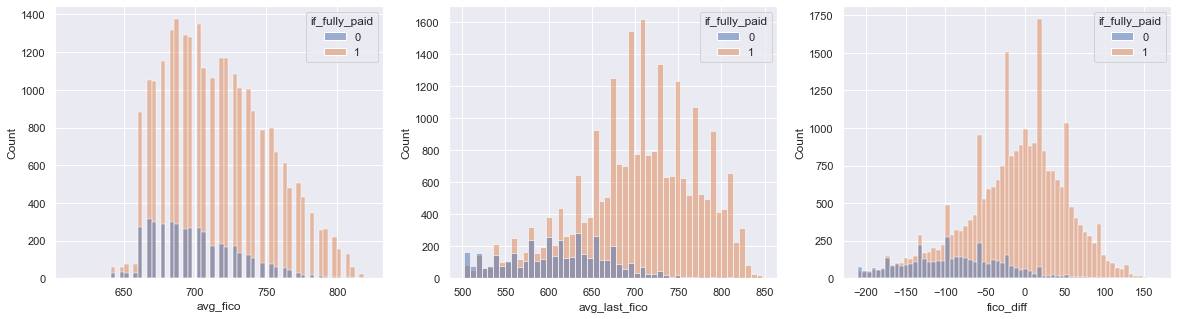

In [152]:
plt.figure(figsize=(20,5))
for i,f in enumerate(new_fico_col):
    plt.subplot(1,3,i+1)
    sns.histplot(data = loan, x=f, hue='if_fully_paid')

In [153]:
range_df = pd.merge(pd.cut(loan.avg_fico, bins=15),loan[['if_charged_off','loan_amnt']],left_index=True, right_index=True)
((range_df.groupby(['avg_fico','if_charged_off']).count()['loan_amnt'])*100/(range_df.groupby('avg_fico').count()['loan_amnt'])).reset_index().pivot(index='avg_fico',columns='if_charged_off')

loan_amnt           
if_charged_off           0          1
avg_fico                             
(611.79, 626.0]  75.000000  25.000000
(626.0, 640.0]   50.000000  50.000000
(640.0, 654.0]   69.395018  30.604982
(654.0, 668.0]   76.676829  23.323171
(668.0, 682.0]   79.881926  20.118074
(682.0, 696.0]   82.898010  17.101990
(696.0, 710.0]   82.824934  17.175066
(710.0, 724.0]   86.833376  13.166624
(724.0, 738.0]   87.765506  12.234494
(738.0, 752.0]   90.307242   9.692758
(752.0, 766.0]   91.965567   8.034433
(766.0, 780.0]   94.278110   5.721890
(780.0, 794.0]   96.213808   3.786192
(794.0, 808.0]   96.531792   3.468208
(808.0, 822.0]   96.703297   3.296703

In [154]:
for f in new_fico_col:
    print(np.corrcoef(loan[f],loan['if_fully_paid']))

[[1.         0.15546978]
 [0.15546978 1.        ]]
[[1.         0.43057494]
 [0.43057494 1.        ]]
[[1.        0.3888897]
 [0.3888897 1.       ]]


#### Zmienne FICO wydają się w pozytywny sposób wpływać na prawdopodobieństwo spłacenia pożyczki. Im wyższy jest scoring FICO lub im wyższa różnica pomiędzy pierwszym a ostatnim scoringiem FICO tym wyższe prawdopodobieństwo spłaty zobowiązania. Wskazuje na to znacząca różnica w częstościach występowania zdarzenia spłaty zobowiązania w górnych wartościach zmiennych FICO oraz dodatni wynik współczynnika korelacji.

<a id='age'></a>

<AxesSubplot:xlabel='credit_age_days', ylabel='Count'>

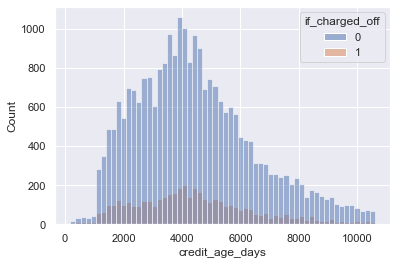

In [155]:
sns.histplot(data=loan, x='credit_age_days',hue='if_charged_off')

In [156]:
range_df = pd.merge(pd.cut(loan.credit_age_days, bins=20),loan[['if_charged_off','loan_amnt']],left_index=True, right_index=True)
((range_df.groupby(['credit_age_days','if_charged_off']).count()['loan_amnt'])*100/(range_df.groupby('credit_age_days').count()['loan_amnt'])).reset_index().pivot(index='credit_age_days',columns='if_charged_off')

loan_amnt           
if_charged_off              0          1
credit_age_days                         
(173.592, 704.4]    73.913043  26.086957
(704.4, 1224.8]     82.420091  17.579909
(1224.8, 1745.2]    83.744466  16.255534
(1745.2, 2265.6]    84.611893  15.388107
(2265.6, 2786.0]    87.198986  12.801014
(2786.0, 3306.4]    86.228983  13.771017
(3306.4, 3826.8]    85.411991  14.588009
(3826.8, 4347.2]    84.685212  15.314788
(4347.2, 4867.6]    84.105090  15.894910
(4867.6, 5388.0]    85.108959  14.891041
(5388.0, 5908.4]    85.929648  14.070352
(5908.4, 6428.8]    84.935065  15.064935
(6428.8, 6949.2]    85.596330  14.403670
(6949.2, 7469.6]    86.712486  13.287514
(7469.6, 7990.0]    85.452323  14.547677
(7990.0, 8510.4]    83.413078  16.586922
(8510.4, 9030.8]    88.911290  11.088710
(9030.8, 9551.2]    85.897436  14.102564
(9551.2, 10071.6]   86.024845  13.975155
(10071.6, 10592.0]  83.935743  16.064257

In [157]:
np.corrcoef(loan.credit_age_days,loan.if_charged_off)

array([[ 1.        , -0.00756907],
       [-0.00756907,  1.        ]])

#### Zmienna wiek kredytowy wydaje się w negatywny sposób wpływać na prawdopodobieństwo niespłaty długu - im wyższy wiek kredytowy tym niższe prawdopodobieństwo niewykonania zobowiązania. Wskazują na to różnice w częstotliwości występowania tego zdarzenia na przekroju wartości tej zmiennej oraz ujemny współczynnik korelacji, jednak jego warość bezwzględna jest na tyle mała, że nie można wnioskować o liniowej zależności

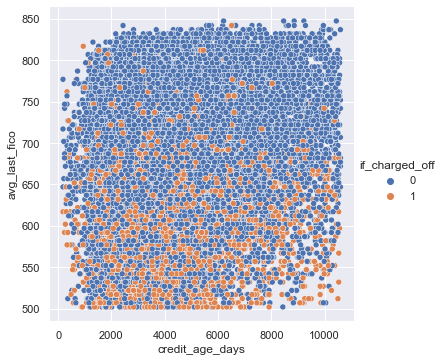

In [158]:
sns.relplot(x='credit_age_days',y='avg_last_fico',hue='if_charged_off', data=loan)

In [159]:
np.corrcoef(loan.avg_last_fico, loan.credit_age_days)

array([[1.        , 0.09794675],
       [0.09794675, 1.        ]])

Wydaje się, że wiek kredytowy oraz wartości FICO negatywnie wpływają na ryzyko niespłaty zobowiązania - im wyższy wiek kredytowy oraz wartość FICO tym mniej zdarzeń niepłaty

<a id='home'></a>

<AxesSubplot:xlabel='home_ownership', ylabel='Count'>

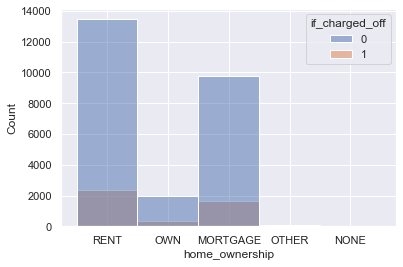

In [160]:
sns.histplot(data=loan, x='home_ownership', hue='if_charged_off')

In [161]:
Cramer_V(loan.home_ownership,loan.if_charged_off)

0.009382254798341767

Status własności domu wydaje się nie mieć wpływu na prawdopodobieństwo niespłaty. Wskazuje na to równomierny rozkład częstotliwości tego zdarzenia w ramach kategorii tej zmiennej oraz współczynnik V Cramera bliski 0.

<a id='inc'></a>

<AxesSubplot:xlabel='annual_inc', ylabel='Count'>

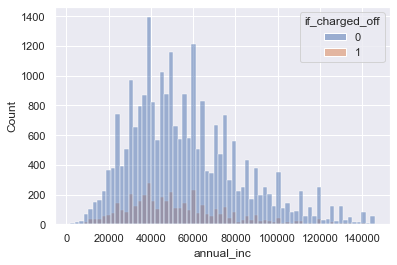

In [162]:
sns.histplot(data=loan, x='annual_inc', hue='if_charged_off')

In [163]:
range_df = pd.merge(pd.cut(loan.annual_inc, bins=20),loan[['if_charged_off','loan_amnt']],left_index=True, right_index=True)
((range_df.groupby(['annual_inc','if_charged_off']).count()['loan_amnt'])*100/(range_df.groupby('annual_inc').count()['loan_amnt'])).reset_index().pivot(index='annual_inc',columns='if_charged_off')

loan_amnt           
if_charged_off                0          1
annual_inc                                
(1751.896, 9101.2]    85.074627  14.925373
(9101.2, 16306.4]     79.310345  20.689655
(16306.4, 23511.6]    83.084577  16.915423
(23511.6, 30716.8]    83.368719  16.631281
(30716.8, 37922.0]    82.906260  17.093740
(37922.0, 45127.2]    83.936324  16.063676
(45127.2, 52332.4]    85.080183  14.919817
(52332.4, 59537.6]    85.106383  14.893617
(59537.6, 66742.8]    84.848485  15.151515
(66742.8, 73948.0]    86.652654  13.347346
(73948.0, 81153.2]    87.118469  12.881531
(81153.2, 88358.4]    89.051095  10.948905
(88358.4, 95563.6]    87.512900  12.487100
(95563.6, 102768.8]   89.600967  10.399033
(102768.8, 109974.0]  87.990196  12.009804
(109974.0, 117179.2]  92.291221   7.708779
(117179.2, 124384.4]  88.829787  11.170213
(124384.4, 131589.6]  92.517007   7.482993
(131589.6, 138794.8]  87.394958  12.605042
(138794.8, 146000.0]  90.588235   9.411765

In [164]:
np.corrcoef(loan.annual_inc, loan.if_charged_off)

array([[ 1.       , -0.0615497],
       [-0.0615497,  1.       ]])

Zmienna roczny dochód wydaje się negatywnie wpływać na prawdopodobieństwo niespłacenia długu, na podstawie ujemnej wartości współczynnika, jednak jego wartość bezwzględna jest na tyle niska, że nie można wnioskować o korelacji liniowej

<a id='emp'></a>

<AxesSubplot:xlabel='emp_length', ylabel='Count'>

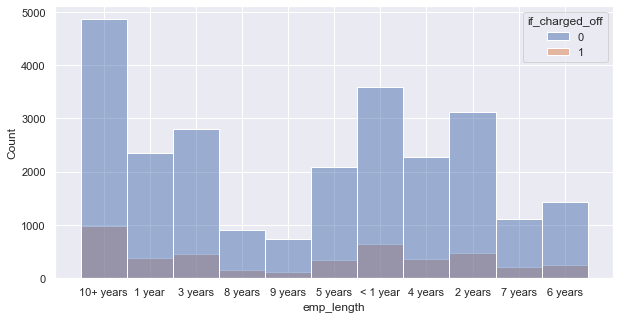

In [165]:
plt.figure(figsize=(10,5))
sns.histplot(data=loan, x='emp_length', hue='if_charged_off')

In [166]:
Cramer_V(loan.emp_length,loan.if_charged_off)

0.02829194263167709

Zmienna długość zatrudnienia wydaje się nie mieć wpływu na ryzyko niespłacenia zadłużenia. Wskazują na to niezróżnicowane częstości występowania tego zdarzenia w ramach grup oraz bliska 0 statystyka V Cramera.

<a id='loan'></a>

<AxesSubplot:xlabel='loan_amnt', ylabel='Count'>

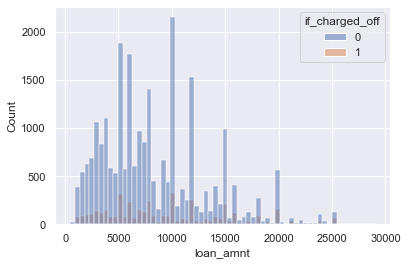

In [167]:
sns.histplot(loan, x='loan_amnt', hue='if_charged_off')

In [168]:
range_df = pd.merge(pd.cut(loan.loan_amnt, bins=20),loan[['if_charged_off','funded_amnt']],left_index=True, right_index=True)
((range_df.groupby(['loan_amnt','if_charged_off']).count()['funded_amnt'])*100/(range_df.groupby('loan_amnt').count()['funded_amnt'])).reset_index().pivot(index='loan_amnt',columns='if_charged_off')

funded_amnt           
if_charged_off               0          1
loan_amnt                                
(471.5, 1925.0]      84.861592  15.138408
(1925.0, 3350.0]     87.470529  12.529471
(3350.0, 4775.0]     88.153565  11.846435
(4775.0, 6200.0]     87.281796  12.718204
(6200.0, 7625.0]     87.793757  12.206243
(7625.0, 9050.0]     86.029162  13.970838
(9050.0, 10475.0]    86.085627  13.914373
(10475.0, 11900.0]   85.601800  14.398200
(11900.0, 13325.0]   85.289453  14.710547
(13325.0, 14750.0]   82.068207  17.931793
(14750.0, 16175.0]   80.308031  19.691969
(16175.0, 17600.0]   79.683377  20.316623
(17600.0, 19025.0]   75.253550  24.746450
(19025.0, 20450.0]   77.353690  22.646310
(20450.0, 21875.0]   62.500000  37.500000
(21875.0, 23300.0]   64.166667  35.833333
(23300.0, 24725.0]   75.000000  25.000000
(24725.0, 26150.0]   65.853659  34.146341
(26150.0, 27575.0]   37.500000  62.500000
(27575.0, 29000.0]   50.000000  50.000000

In [169]:
np.corrcoef(loan.loan_amnt,loan.if_charged_off)

array([[1.        , 0.09683062],
       [0.09683062, 1.        ]])

Na podstawie różnic w częstotliwościach występowania niespłaty kredytu wydaje się, że wysokość pożyczki pozytwywnie wpływa na prawdopodobieństwo niewykonania zobowiązania - im wyższa pożyczka tym większa częstotliwość występowania niespłaty, a w konsekwencji jej prawdopodobieństwo. Współczynnik korelacji, chociaż dodatni, to jednak niewielki, co nie wskazuje jednoznacznie na korelację.

<a id='std'></a>
### Standaryzacja oraz dummies

In [170]:
col_num.remove('if_charged_off')

In [171]:
scaler = preprocessing.StandardScaler()

In [172]:
loan_num_std = scaler.fit_transform(loan[col_num])

In [173]:
org_index = loan[col_num].index

In [174]:
loan_num_std_df = pd.DataFrame(loan_num_std, columns=col_num, index=org_index)
loan_num_std_df

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
0      -0.702253    -0.695708        -0.587835 -0.277885    -0.625408   
2      -1.210933    -1.224977        -1.114201  1.283536    -1.134146   
3       0.275978     0.322118         0.439346  0.557225     0.517471   
4      -1.093545    -1.102838        -0.991553  0.321983    -1.241282   
5      -0.702253    -0.695708        -0.582724 -1.086530    -0.666928   
...          ...          ...              ...       ...          ...   
42507  -1.289191    -1.306403        -1.395270  0.354329    -1.245104   
42508  -0.506607    -0.492143        -1.359498  0.448426    -0.368642   
42509  -0.633777    -0.624460        -1.477036  0.448426    -0.510757   
42513  -0.506607    -0.492143        -1.471926 -0.295528    -0.415474   
42514  -0.819641    -0.817847        -1.318615 -0.574878    -0.765450   

       annual_inc       dti  open_acc  revol_bal  revol_util  ...  \
0       -1.228285  2.154261 -1.440722   0.566664    1.267514  ...   
2       -1.677740 -0.657324 -1.694751  -0.777294    1.792249  ...   
3       -0.264182  1.018042  0.337484  -0.445201   -0.955522  ...   
4        0.914166  0.712079  1.607631   2.343399    0.210951  ...   
5       -0.769188 -0.288981  0.083454  -0.147926   -0.696700  ...   
...           ...       ...       ...        ...         ...  ...   
42507   -1.763897 -1.435597 -1.694751  -1.077082    0.494592  ...   
42508   -1.687381 -1.298954  1.607631  -0.488818    0.047858  ...   
42509   -1.993446  0.275415 -1.948781  -1.148856    0.037221  ...   
42513   -1.381317 -0.036488 -0.932663   0.568173    0.639958  ...   
42514   -0.998737 -1.399951 -1.186693  -0.709794    0.551320  ...   

       total_pymnt_inv  total_rec_prncp  total_rec_int  last_pymnt_amnt  \
0            -0.459664        -0.507345      -0.511868        -0.636372   
2            -0.952313        -1.041075      -0.716056        -0.371915   
3             0.654834         0.519059       0.560069        -0.533606   
4            -0.767452        -0.917907      -0.350296        -0.694053   
5            -0.494787        -0.507345      -0.695010        -0.642228   
...                ...              ...            ...              ...   
42507        -1.259916        -1.123188      -0.863989        -0.693495   
42508        -1.221898        -0.302064      -0.173197        -0.618109   
42509        -1.343877        -0.435497      -0.306792        -0.146859   
42513        -1.343220        -0.302064      -0.379668        -0.622140   
42514        -1.194059        -0.630514      -0.653370        -0.652042   

       last_pymnt_days_after_issue  credit_age_days  \
0                         0.577870         2.615261   
2                         0.043215        -0.377273   
3                         0.577870         0.644900   
4                         2.404190         0.659990   
5                         0.577870        -0.910750   
...                            ...              ...   
42507                     0.500420        -1.592198   
42508                     0.500420        -1.710965   
42509                     0.125662        -2.066292   
42513                     0.500420        -0.140226   
42514                     0.500420        -1.651095   

       days_from_issue_to_last_cred_pull  avg_fico  avg_last_fico  fico_diff  
0                               0.515587  0.650834       0.622302   0.339433  
2                               0.019899  0.650834       0.622302   0.339433  
3                              -0.475788 -0.600884      -1.174482  -0.968409  
4                               0.373629 -0.461804      -0.109721   0.121460  
5                              -0.119731  0.511754      -1.706862  -2.130935  
...                                  ...       ...            ...        ...  
42507                           2.393614 -1.852602       0.356111   1.356644  
42508                          -0.119731 -1.574442      -0.375911   0.412091  
42509                       

In [175]:
cramer_df.sort_values(by='Cramer_V_with_if_charged',ascending=False)

Cramer_V_with_if_charged
sub_grade                             0.240029
grade                                 0.234257
term                                  0.183892
late_fee_range                        0.176451
debt_settlement_flag                  0.126938
inq_last_6mths                        0.122376
purpose                               0.092109
zip_code                              0.086952
pub_rec                               0.066207
pub_rec_bankruptcies                  0.056863
addr_state                            0.056619
verification_status                   0.055175
delinq_2yrs                           0.031342
emp_length                            0.028292
home_ownership                        0.009382

In [176]:
cramer_df[cramer_df['Cramer_V_with_if_charged']>0.1] 
## Wybór zmiennych kategorycznych z współczynnikiem większym niż 10%

Cramer_V_with_if_charged
term                                  0.183892
grade                                 0.234257
sub_grade                             0.240029
debt_settlement_flag                  0.126938
late_fee_range                        0.176451
inq_last_6mths                        0.122376

In [177]:
selected_cat = cramer_df[cramer_df['Cramer_V_with_if_charged']>0.1].index 

In [178]:
loan_dumm = pd.get_dummies(loan[selected_cat], columns=selected_cat, drop_first=True)

In [179]:
loan_dumm

term_ 60 months  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G  \
0                    0        1        0        0        0        0        0   
2                    0        0        1        0        0        0        0   
3                    0        0        1        0        0        0        0   
4                    1        1        0        0        0        0        0   
5                    0        0        0        0        0        0        0   
...                ...      ...      ...      ...      ...      ...      ...   
42507                0        0        0        1        0        0        0   
42508                0        0        0        1        0        0        0   
42509                0        0        0        1        0        0        0   
42513                0        0        1        0        0        0        0   
42514                0        1        0        0        0        0        0   

       sub_grade_A2  sub_grade_A3  sub_grade_A4  ...  inq_last_6mths_16  \
0                 0             0             0  ...                  0   
2                 0             0             0  ...                  0   
3                 0             0             0  ...                  0   
4                 0             0             0  ...                  0   
5                 0             0             1  ...                  0   
...             ...           ...           ...  ...                ...   
42507             0             0             0  ...                  0   
42508             0             0             0  ...                  0   
42509             0             0             0  ...                  0   
42513             0             0             0  ...                  0   
42514             0             0             0  ...                  0   

       inq_last_6mths_17  inq_last_6mths_18  inq_last_6mths_19  \
0                      0                  0                  0   
2                      0                  0                  0   
3                      0                  0                  0   
4                      0                  0                  0   
5                      0                  0                  0   
...                  ...                ...                ...   
42507                  0                  0                  0   
42508                  0                  0                  0   
42509                  0                  0                  0   
42513                  0                  0                  0   
42514                  0                  0                  0   

       inq_last_6mths_20  inq_last_6mths_24  inq_last_6mths_28  \
0                      0                  0                  0   
2                      0                  0                  0   
3                      0                  0                  0   
4                      0                  0                  0   
5                      0                  0                  0   
...                  ...                ...                ...   
42507                  0                  0                  0   
42508                  0                  0                  0   
42509                  0                  0                  0   
42513                  0                  0                  0   
42514                  0                  0                  0   

       inq_last_6mths_31  inq_last_6mths_32  inq_last_6mths_33  
0                      0                  0                  0  
2                      0                  0                  0  
3                      0                  0                  0  
4                      0                  0                  0  
5                      0                  0                  0  
...                  ...                ...                ...  
42507                  0                  0                  0  
42508                  0               

In [180]:
x = pd.merge(loan_num_std_df, loan_dumm,left_index=True, right_index=True)
x

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
0      -0.702253    -0.695708        -0.587835 -0.277885    -0.625408   
2      -1.210933    -1.224977        -1.114201  1.283536    -1.134146   
3       0.275978     0.322118         0.439346  0.557225     0.517471   
4      -1.093545    -1.102838        -0.991553  0.321983    -1.241282   
5      -0.702253    -0.695708        -0.582724 -1.086530    -0.666928   
...          ...          ...              ...       ...          ...   
42507  -1.289191    -1.306403        -1.395270  0.354329    -1.245104   
42508  -0.506607    -0.492143        -1.359498  0.448426    -0.368642   
42509  -0.633777    -0.624460        -1.477036  0.448426    -0.510757   
42513  -0.506607    -0.492143        -1.471926 -0.295528    -0.415474   
42514  -0.819641    -0.817847        -1.318615 -0.574878    -0.765450   

       annual_inc       dti  open_acc  revol_bal  revol_util  ...  \
0       -1.228285  2.154261 -1.440722   0.566664    1.267514  ...   
2       -1.677740 -0.657324 -1.694751  -0.777294    1.792249  ...   
3       -0.264182  1.018042  0.337484  -0.445201   -0.955522  ...   
4        0.914166  0.712079  1.607631   2.343399    0.210951  ...   
5       -0.769188 -0.288981  0.083454  -0.147926   -0.696700  ...   
...           ...       ...       ...        ...         ...  ...   
42507   -1.763897 -1.435597 -1.694751  -1.077082    0.494592  ...   
42508   -1.687381 -1.298954  1.607631  -0.488818    0.047858  ...   
42509   -1.993446  0.275415 -1.948781  -1.148856    0.037221  ...   
42513   -1.381317 -0.036488 -0.932663   0.568173    0.639958  ...   
42514   -0.998737 -1.399951 -1.186693  -0.709794    0.551320  ...   

       inq_last_6mths_16  inq_last_6mths_17  inq_last_6mths_18  \
0                      0                  0                  0   
2                      0                  0                  0   
3                      0                  0                  0   
4                      0                  0                  0   
5                      0                  0                  0   
...                  ...                ...                ...   
42507                  0                  0                  0   
42508                  0                  0                  0   
42509                  0                  0                  0   
42513                  0                  0                  0   
42514                  0                  0                  0   

       inq_last_6mths_19  inq_last_6mths_20  inq_last_6mths_24  \
0                      0                  0                  0   
2                      0                  0                  0   
3                      0                  0                  0   
4                      0                  0                  0   
5                      0                  0                  0   
...                  ...                ...                ...   
42507                  0                  0                  0   
42508                  0                  0                  0   
42509                  0                  0                  0   
42513                  0                  0                  0   
42514                  0                  0                  0   

       inq_last_6mths_28  inq_last_6mths_31  inq_last_6mths_32  \
0                      0                  0                  0   
2                      0                  0                  0   
3                      0                  0                  0   
4                      0                  0                  0   
5                      0                  0                  0   
...                  ...                ...                ...   
42507                  0                  0                  0   
42508                  0                  0                  0   
42509                  0                  0                  0   
42513                  0                  0            

In [181]:
y = loan['if_charged_off']
y

0        0
2        0
3        0
4        0
5        0
        ..
42507    0
42508    0
42509    0
42513    0
42514    0
Name: if_charged_off, Length: 29654, dtype: uint8

In [182]:
loan_x_y = pd.merge(x,y, left_index=True, right_index=True)

<a id='clust'></a>
## Klasteryzacja 

<a id='kmean'></a>

In [183]:
kmean = KMeans(n_clusters=5, max_iter=1000)

In [184]:
kmean.fit(loan_x_y)

KMeans(max_iter=1000, n_clusters=5)

In [185]:
kmean.labels_

array([0, 3, 2, ..., 3, 3, 3])

In [186]:
kmean.inertia_

476755.36989617435

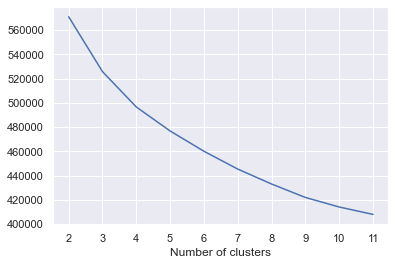

In [187]:
inert = []
n_clusters = range(2,12)
for n in n_clusters:
    kmean = KMeans(n_clusters = n)
    kmean.fit(loan_x_y)
    inert.append(kmean.inertia_)
plt.plot(inert)
plt.xticks(ticks = range(0,10),labels = n_clusters)
plt.xlabel('Number of clusters')
plt.show()

In [188]:
kmean = KMeans(n_clusters=7, max_iter=1000)

In [189]:
kmean.fit(loan_x_y)

KMeans(max_iter=1000, n_clusters=7)

In [190]:
kmean.inertia_

445305.43987296044

In [191]:
n_clusters = range(2,9)

for n in n_clusters:
    kmean = KMeans(n_clusters = n, max_iter=1000)
    kmean.fit(loan_x_y)
    cl_lab = kmean.labels_
    av_sil = metrics.silhouette_score(loan_x_y,cl_lab)
    print(f'For {n} clusters the average silhouette_score is: {round(av_sil,2)}')

For 2 clusters the average silhouette_score is: 0.2
For 3 clusters the average silhouette_score is: 0.12
For 4 clusters the average silhouette_score is: 0.11
For 5 clusters the average silhouette_score is: 0.1
For 6 clusters the average silhouette_score is: 0.09
For 7 clusters the average silhouette_score is: 0.09
For 8 clusters the average silhouette_score is: 0.09


Największy spadek inercji można zauważyć między podziałem na 3, 4 klastry. Jendak współczynnik silhouett jest na tyle mały, że nie można wnioskować o istotnej różnorodności tych klastrów

In [192]:
kmean = KMeans(n_clusters=4,max_iter=1000)

In [193]:
kmean.fit(loan_num_std_df)

KMeans(max_iter=1000, n_clusters=4)

In [194]:
kmean.inertia_

431534.06643880816

In [195]:
metrics.silhouette_score(loan_num_std_df,kmean.labels_)

0.11865190555358812

Uwzględniając tylko zmienne numeryczne nie widać istotnej poprawy współczynników

In [196]:
kmean.fit(loan_x_y)

KMeans(max_iter=1000, n_clusters=4)

In [197]:
loan_x_y['kmean_labels'] = kmean.fit(loan_x_y).labels_

<AxesSubplot:xlabel='kmean_labels', ylabel='credit_age_days'>

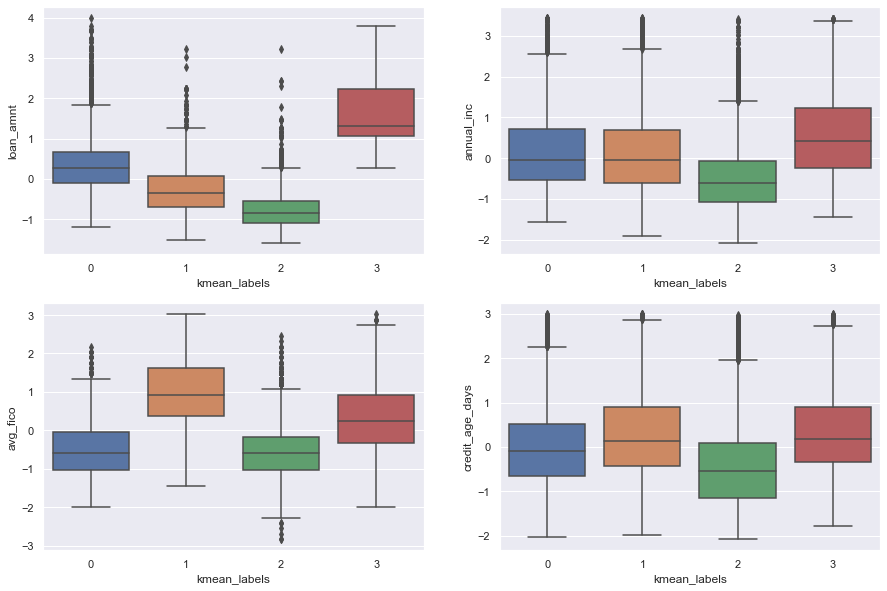

In [198]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.boxplot(data=loan_x_y, x='kmean_labels', y='loan_amnt')
plt.subplot(2,2,2)
sns.boxplot(data=loan_x_y, x='kmean_labels', y='annual_inc')
plt.subplot(2,2,3)
sns.boxplot(data=loan_x_y, x='kmean_labels', y='avg_fico')
plt.subplot(2,2,4)
sns.boxplot(data=loan_x_y, x='kmean_labels', y='credit_age_days')

<a id='dbscan'></a>

In [199]:
db_class = DBSCAN()

In [200]:
db_class.fit(loan_x_y)

DBSCAN()

In [201]:
db_labels = db_class.labels_
db_labels

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [202]:
len(set(db_labels))

1

In [203]:
db_class.fit(loan_num_std_df)

DBSCAN()

In [204]:
db_labels = db_class.labels_
db_labels

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [205]:
set(db_labels)

{-1}

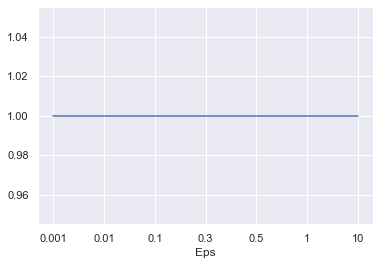

In [206]:
eps = [0.001, 0.01, 0.1, 0.3, 0.5, 1, 10]
clust_no = []
for e in eps:
    db_class = DBSCAN()
    db_class.fit(loan_x_y)
    clust_no.append(len(set(db_class.labels_)))
plt.plot(clust_no)
plt.xticks(ticks = range(0,7),labels = eps)
plt.xlabel('Eps')
plt.show()

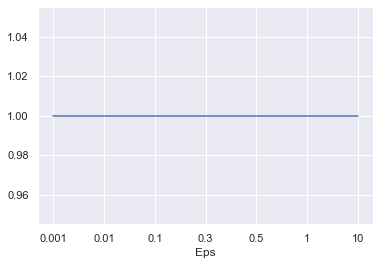

In [207]:
eps = [0.001, 0.01, 0.1, 0.3, 0.5, 1, 10]
clust_no = []
for e in eps:
    db_class = DBSCAN()
    db_class.fit(loan_num_std_df)
    clust_no.append(len(set(db_class.labels_)))
plt.plot(clust_no)
plt.xticks(ticks = range(0,7),labels = eps)
plt.xlabel('Eps')
plt.show()

Algorytm DBSCAN nie znalazł istotnych segmentów w zbiorze pożyczkobiorców

<a id='models'></a>
## Modele klasyfikatorów

In [208]:
models = pd.DataFrame(index=range(0,10),columns=('Model','AUROC_train','CV_AUROC_train_avg',
                                                'CV_AUROC_train_std','AUROC_test','CV_AUROC_test_avg','CV_AUROC_test_std'))

In [209]:
loan_num_y = pd.merge(loan_num_std_df,y,left_index = True, right_index=True)

<AxesSubplot:>

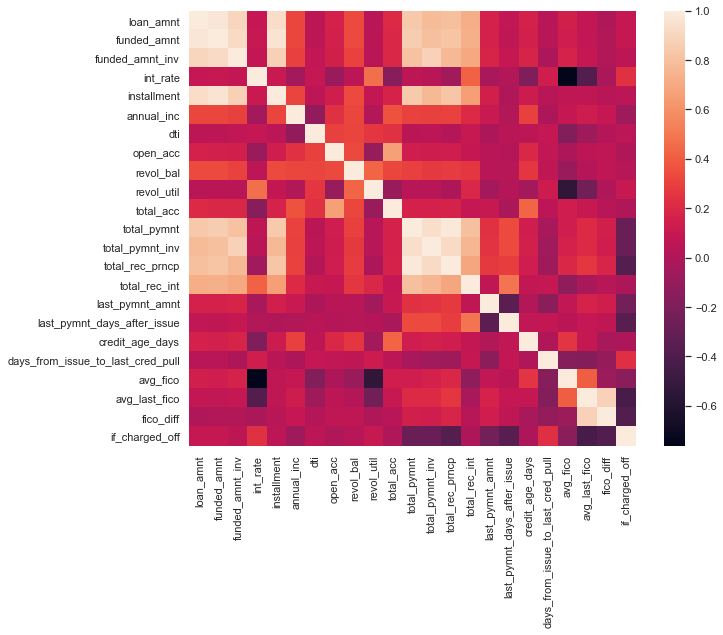

In [210]:
corr_mat = loan_num_y.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_mat)

In [211]:
np.abs(corr_mat.if_charged_off).sort_values(ascending=False).head(10)

if_charged_off                       1.000000
avg_last_fico                        0.430575
fico_diff                            0.388890
total_rec_prncp                      0.371850
last_pymnt_days_after_issue          0.353635
total_pymnt                          0.283866
total_pymnt_inv                      0.280905
last_pymnt_amnt                      0.242298
int_rate                             0.236626
days_from_issue_to_last_cred_pull    0.230069
Name: if_charged_off, dtype: float64

<AxesSubplot:>

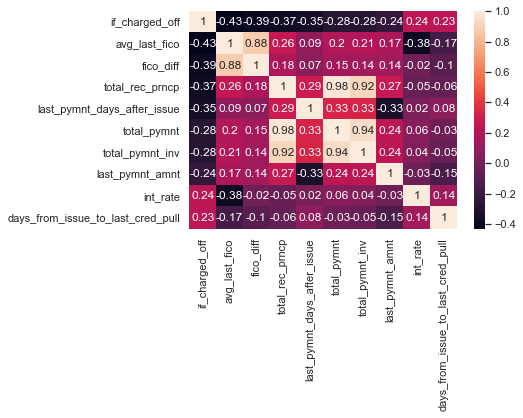

In [212]:
sns.heatmap(round(loan_num_y[np.abs(corr_mat.if_charged_off).sort_values(ascending=False).head(10).index].corr(),2),annot=True)

Zmiennymi najbardziej skorelowanymi ze zmienną i słabo skorelowane ze sobą wydają się być: last_fico, total_rec_prncp, last_payment_days, days_to_last_credit_pull

In [213]:
x_cols = ['avg_last_fico', 'total_rec_prncp', 'last_pymnt_days_after_issue','days_from_issue_to_last_cred_pull']

In [214]:
x = loan_num_y[x_cols]
y = loan_num_y.if_charged_off

In [215]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

In [216]:
print(f'Rozmiar treningowy: {x_train.shape}')
print(f'Rozmiar testowy: {x_test.shape}')

Rozmiar treningowy: (23723, 4)
Rozmiar testowy: (5931, 4)


In [217]:
kfold = StratifiedKFold(n_splits=20,shuffle=True,random_state=0) 

<a id='logist1'></a>
### Model regresji logistycznej (zmienne numeryczne)

In [218]:
logistic_model = LogisticRegression()

In [219]:
logistic_model.fit(x_train,y_train)

LogisticRegression()

In [220]:
logistic_model.score(x_train,y_train)

0.9140918096362181

In [221]:
metrics.roc_auc_score(y_train,logistic_model.predict(x_train))

0.7888618291710998

In [222]:
cv_auroc_score = cross_val_score(logistic_model,x_train,y_train,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_auroc_score

array([0.75023042, 0.78567856, 0.80877394, 0.81571287, 0.78318497,
       0.78219585, 0.79137205, 0.78900947, 0.79461354, 0.7651632 ,
       0.79362442, 0.79747068, 0.79175639, 0.78241628, 0.77324007,
       0.79087749, 0.79764851, 0.76319194, 0.80614874, 0.80528803])

In [223]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: {round(np.mean(cv_auroc_score),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: {round(cv_auroc_score.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: 0.7884
Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: 0.0158


In [224]:
logistic_model.coef_

array([[-1.33442441, -1.41770205, -1.02688022,  0.81344857]])

<AxesSubplot:>

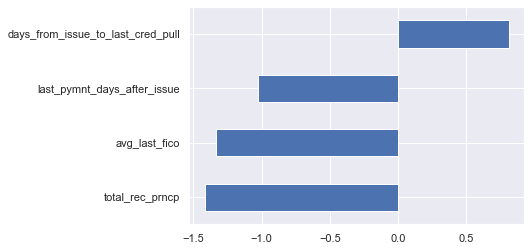

In [225]:
pd.DataFrame(logistic_model.coef_[0],index=x_cols,columns=['Coefficient']).Coefficient.sort_values().plot.barh()

Współczynniki modelu wskazują pozytywny wpływ zmiennej 'days from last cred pull' na prawdopodobieństwo niespłaty kredytu - im później po otrzymaniu kredytu LC sprawdza informację kredytową tym większe ryzyko niespłaty. Pozostałe zmienne mają negatywny wpływ na prawdopodobieństwo niespłacenia - im większa wartość kapitału została już spłacona, im wyższy scoring FICO, im później od dnia otrzymania kredytu nastąpiła ostatnia płatność, tym mniejsze ryzyko niespłacenia zobowiązania

In [226]:
metrics.roc_auc_score(y_test,logistic_model.predict(x_test))

0.8133781161178767

In [227]:
cv_test = cross_val_score(logistic_model,x_test,y_test,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_test

array([0.78359684, 0.82905138, 0.79249012, 0.81768775, 0.80039526,
       0.85375494, 0.80632411, 0.86660079, 0.85721344, 0.81175889,
       0.76482213, 0.80627706, 0.82106782, 0.83784271, 0.8270202 ,
       0.84974747, 0.73466811, 0.79616693, 0.76325949, 0.83500322])

In [228]:
models.loc[models.index==0,'Model']='Regresja logistyczna (zm.num)'
models.loc[models.index==0,'AUROC_train']=metrics.roc_auc_score(y_train,logistic_model.predict(x_train))
models.loc[models.index==0,'CV_AUROC_train_avg']=np.mean(cv_auroc_score)
models.loc[models.index==0,'CV_AUROC_train_std']=cv_auroc_score.std()
models.loc[models.index==0,'AUROC_test']=metrics.roc_auc_score(y_test,logistic_model.predict(x_test))
models.loc[models.index==0,'CV_AUROC_test_avg']=np.mean(cv_test)
models.loc[models.index==0,'CV_AUROC_test_std']=cv_test.std()

<a id='logist2'></a>
### Model regresji logistycznej (zmienne numeryczne i kategoryczne)

In [229]:
x_cols

['avg_last_fico',
 'total_rec_prncp',
 'last_pymnt_days_after_issue',
 'days_from_issue_to_last_cred_pull']

In [230]:
cramer_df.sort_values(by='Cramer_V_with_if_charged', ascending=False).head()

Cramer_V_with_if_charged
sub_grade                             0.240029
grade                                 0.234257
term                                  0.183892
late_fee_range                        0.176451
debt_settlement_flag                  0.126938

In [231]:
grade_col = loan_dumm.columns[loan_dumm.columns.str.contains('sub_grade')]

In [232]:
corr_num_cat = pd.merge(loan_num_y[x_cols], loan_dumm[grade_col], left_index=True, right_index=True).corr()[['avg_last_fico','total_rec_prncp','last_pymnt_days_after_issue','days_from_issue_to_last_cred_pull']]

In [233]:
corr_num_cat.iloc[4:,:][corr_num_cat>0.2].count()

avg_last_fico                        0
total_rec_prncp                      0
last_pymnt_days_after_issue          0
days_from_issue_to_last_cred_pull    0
dtype: int64

In [234]:
x_num_cat = pd.merge(loan_num_y[x_cols], loan_dumm[grade_col], left_index=True, right_index=True)

In [235]:
x_train, x_test, y_train, y_test = train_test_split(x_num_cat,y, test_size=0.2, random_state=1, stratify=y)
print(f'Rozmiar treningowy: {x_train.shape}')
print(f'Rozmiar testowy: {x_test.shape}')

Rozmiar treningowy: (23723, 38)
Rozmiar testowy: (5931, 38)


In [236]:
logistic_model_2 = LogisticRegression(max_iter=500)

In [237]:
logistic_model_2.fit(x_train,y_train)

LogisticRegression(max_iter=500)

In [238]:
logistic_model_2.score(x_train,y_train)

0.9181806685495089

In [239]:
metrics.roc_auc_score(y_train,logistic_model_2.predict(x_train))

0.7977420702718031

In [240]:
cv_auroc_score = cross_val_score(logistic_model_2,x_train,y_train,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_auroc_score

array([0.76974867, 0.78716224, 0.81445576, 0.81868023, 0.79087749,
       0.7984598 , 0.78466864, 0.79659178, 0.79994348, 0.78615232,
       0.80554755, 0.80653667, 0.78604211, 0.78291084, 0.78999859,
       0.78417409, 0.79345185, 0.77257538, 0.82196782, 0.82233348])

In [241]:
np.mean(cv_auroc_score)

0.7956139392314603

In [242]:
cv_test = cross_val_score(logistic_model_2,x_test,y_test,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_test

array([0.75889328, 0.80237154, 0.80978261, 0.80632411, 0.81768775,
       0.85177866, 0.78359684, 0.86264822, 0.84782609, 0.81373518,
       0.7534585 , 0.80826118, 0.83044733, 0.83784271, 0.8270202 ,
       0.83639971, 0.75937951, 0.80384226, 0.77686368, 0.81372369])

In [243]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych testowych: {round(np.mean(cv_test),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych testowych: {round(cv_test.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych testowych: 0.8101
Standardowe odchylenie auroc dla 20k cross-walidacji na danych testowych: 0.0304


In [244]:
models.loc[models.index==1,'Model']='Regresja logistyczna (zm.num i kat)'
models.loc[models.index==1,'AUROC_train']=metrics.roc_auc_score(y_train,logistic_model_2.predict(x_train))
models.loc[models.index==1,'CV_AUROC_train_avg']=np.mean(cv_auroc_score)
models.loc[models.index==1,'CV_AUROC_train_std']=cv_auroc_score.std()
models.loc[models.index==1,'AUROC_test']=metrics.roc_auc_score(y_test,logistic_model_2.predict(x_test))
models.loc[models.index==1,'CV_AUROC_test_avg']=np.mean(cv_test)
models.loc[models.index==1,'CV_AUROC_test_std']=cv_test.std()

<a id='tree'></a>
### Drzewo decyzyjne

In [245]:
loan_num_std_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'open_acc', 'revol_bal',
       'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt',
       'last_pymnt_days_after_issue', 'credit_age_days',
       'days_from_issue_to_last_cred_pull', 'avg_fico', 'avg_last_fico',
       'fico_diff'],
      dtype='object')

In [246]:
loan_dumm.columns

Index(['term_ 60 months', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5',
       'debt_settlement_flag_Y', 'late_fee_range_1', 'late_fee_range_2',
       'late_fee_range_3', 'late_fee_range_4', 'inq_last_6mths_1',
       'inq_last_6mths_2', 'inq_last_6mths_3', 'inq_last_6mths_4',
       'inq_last_6mths_5', 'inq_last_6mths_6', 'inq_last_6mths_7',
       'inq_last_6mths_8', 

In [247]:
loan_num_cat = pd.merge(loan_num_std_df, loan_dumm, left_index=True, right_index=True)

In [248]:
x = loan_num_cat
y = loan.if_charged_off

In [249]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)
print(f'Rozmiar treningowy: {x_train.shape}')
print(f'Rozmiar testowy: {x_test.shape}')

Rozmiar treningowy: (23723, 93)
Rozmiar testowy: (5931, 93)


In [250]:
dec_tree_model = tree.DecisionTreeClassifier(min_samples_leaf=10)

In [251]:
dec_tree_model.fit(x_train,y_train)

DecisionTreeClassifier(min_samples_leaf=10)

In [252]:
dec_tree_model.score(x_train,y_train)

0.9911899844033216

In [253]:
metrics.roc_auc_score(y_train,dec_tree_model.predict(x_train))

0.9770371208512931

In [254]:
cv_auroc_score = cross_val_score(dec_tree_model,x_train,y_train,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_auroc_score

array([0.96812899, 0.97294814, 0.96948622, 0.96659319, 0.97043945,
       0.94758231, 0.94994489, 0.97516462, 0.96747209, 0.96510951,
       0.95604352, 0.96423061, 0.96609863, 0.9541755 , 0.97802176,
       0.95901088, 0.96194869, 0.95491112, 0.98183506, 0.96108798])

In [255]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: {round(np.mean(cv_auroc_score),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: {round(cv_auroc_score.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: 0.9645
Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: 0.0089


In [256]:
dec_tree_model.score(x_test,y_test)

0.9854999156971843

In [257]:
metrics.roc_auc_score(y_test,dec_tree_model.predict(x_test))

0.9684033870910247

In [258]:
cv_test = cross_val_score(dec_tree_model,x_test,y_test,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_test

array([0.95998024, 0.90513834, 0.95454545, 0.91057312, 0.91847826,
       0.90711462, 0.92786561, 0.9298419 , 0.96195652, 0.96343874,
       0.92786561, 0.93921356, 0.93181818, 0.95598846, 0.9505772 ,
       0.91648629, 0.94660895, 0.94755952, 0.9243037 , 0.91069951])

In [259]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych testowych: {round(np.mean(cv_test),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych testowych: {round(cv_test.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych testowych: 0.9345
Standardowe odchylenie auroc dla 20k cross-walidacji na danych testowych: 0.019


In [260]:
dt_feat_imp = pd.DataFrame(dec_tree_model.feature_importances_,index=x.columns,columns=['Feature_importance'])
dt_feat_imp.sort_values(by='Feature_importance', ascending=False).head(10)

Feature_importance
total_rec_prncp                              0.321894
funded_amnt                                  0.254982
last_pymnt_amnt                              0.186521
last_pymnt_days_after_issue                  0.096264
avg_last_fico                                0.080336
term_ 60 months                              0.013353
installment                                  0.011640
debt_settlement_flag_Y                       0.009542
loan_amnt                                    0.008160
days_from_issue_to_last_cred_pull            0.005943

In [261]:
imp_feat= dt_feat_imp.sort_values(by='Feature_importance', ascending=False).head(5).index

In [262]:
models.loc[models.index==2,'Model']='Drzewo decyzyjne (wszystkie zmienne)'
models.loc[models.index==2,'AUROC_train']=metrics.roc_auc_score(y_train,dec_tree_model.predict(x_train))
models.loc[models.index==2,'CV_AUROC_train_avg']=np.mean(cv_auroc_score)
models.loc[models.index==2,'CV_AUROC_train_std']=cv_auroc_score.std()
models.loc[models.index==2,'AUROC_test']=metrics.roc_auc_score(y_test, dec_tree_model.predict(x_test))
models.loc[models.index==2,'CV_AUROC_test_avg']=np.mean(cv_test)
models.loc[models.index==2,'CV_AUROC_test_std']=cv_test.std()

### Drzewo decyzyjne (najważnejsze zmienne)

In [263]:
x = loan_num_cat[imp_feat]
y = loan.if_charged_off
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)
print(f'Rozmiar treningowy: {x_train.shape}')
print(f'Rozmiar testowy: {x_test.shape}')

Rozmiar treningowy: (23723, 5)
Rozmiar testowy: (5931, 5)


In [264]:
dec_tree_model_2 = tree.DecisionTreeClassifier(min_samples_leaf=10,max_depth=5)

In [265]:
dec_tree_model_2.fit(x_train,y_train)
dec_tree_model_2.score(x_train,y_train)

0.9668254436622686

In [266]:
metrics.roc_auc_score(y_train,dec_tree_model_2.predict(x_train))

0.9194945585678663

In [267]:
cv_auroc_score = cross_val_score(dec_tree_model_2,x_train,y_train,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_auroc_score

array([0.90649166, 0.91686618, 0.92773525, 0.92313127, 0.93692242,
       0.90499929, 0.92302105, 0.90313127, 0.91357072, 0.91879045,
       0.92648297, 0.92450473, 0.91741698, 0.92785644, 0.92736188,
       0.91868023, 0.89944869, 0.90784203, 0.92525315, 0.91462084])

In [268]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: {round(np.mean(cv_auroc_score),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: {round(cv_auroc_score.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: 0.9182
Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: 0.0096


In [269]:
dec_tree_model_2.score(x_test,y_test)

0.966278873714382

In [270]:
metrics.roc_auc_score(y_test,dec_tree_model_2.predict(x_test))

0.9231992316505121

In [271]:
cv_test = cross_val_score(dec_tree_model_2,x_test,y_test,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_test

array([0.95998024, 0.93527668, 0.91650198, 0.92786561, 0.93725296,
       0.93527668, 0.91057312, 0.94268775, 0.95405138, 0.96343874,
       0.89525692, 0.92189755, 0.91648629, 0.96194084, 0.9520202 ,
       0.89718615, 0.96933622, 0.92627999, 0.92035114, 0.91837485])

Text(1088.1, 45.299999999999955, 'gini = 0.005\nsamples = 7694\nvalue = [7676, 18]')

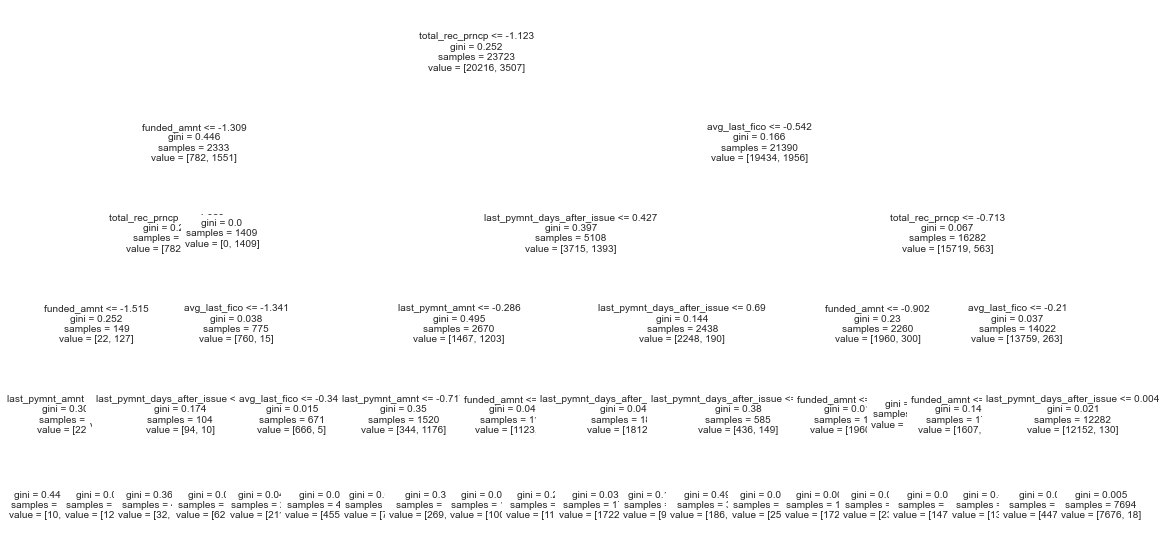

In [272]:
plt.figure(figsize=(20,10))
tree.plot_tree(dec_tree_model_2, feature_names=x.columns, fontsize=10)[-1]

In [273]:
models.loc[models.index==3,'Model']='Drzewo decyzyjne (najważniejsze zmienne)'
models.loc[models.index==3,'AUROC_train']=metrics.roc_auc_score(y_train,dec_tree_model_2.predict(x_train))
models.loc[models.index==3,'CV_AUROC_train_avg']=np.mean(cv_auroc_score)
models.loc[models.index==3,'CV_AUROC_train_std']=cv_auroc_score.std()
models.loc[models.index==3,'AUROC_test']=metrics.roc_auc_score(y_test, dec_tree_model_2.predict(x_test))
models.loc[models.index==3,'CV_AUROC_test_avg']=np.mean(cv_test)
models.loc[models.index==3,'CV_AUROC_test_std']=cv_test.std()

<a id='forest'></a>
### Las losowy

In [274]:
features = dt_feat_imp.sort_values(by='Feature_importance', ascending=False).head(20).index

In [275]:
features

Index(['total_rec_prncp', 'funded_amnt', 'last_pymnt_amnt',
       'last_pymnt_days_after_issue', 'avg_last_fico', 'term_ 60 months',
       'installment', 'debt_settlement_flag_Y', 'loan_amnt',
       'days_from_issue_to_last_cred_pull', 'total_rec_int', 'int_rate',
       'credit_age_days', 'fico_diff', 'revol_bal', 'revol_util', 'dti',
       'funded_amnt_inv', 'total_pymnt_inv', 'avg_fico'],
      dtype='object')

In [276]:
x = loan_num_cat[features]
y = loan.if_charged_off
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)
print(f'Rozmiar treningowy: {x_train.shape}')
print(f'Rozmiar testowy: {x_test.shape}')

Rozmiar treningowy: (23723, 20)
Rozmiar testowy: (5931, 20)


In [277]:
random_forest_model = RandomForestClassifier(n_jobs=-1)

In [278]:
random_forest_model.fit(x_train,y_train)
random_forest_model.score(x_train,y_train)

1.0

In [279]:
cv_auroc_score = cross_val_score(random_forest_model,x_train,y_train,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_auroc_score

array([0.97443182, 0.97159091, 0.97961908, 0.96857143, 0.96807687,
       0.96571429, 0.96472517, 0.97714286, 0.97428571, 0.97428571,
       0.96807687, 0.9766483 , 0.96857143, 0.97379115, 0.98285714,
       0.97428571, 0.96590909, 0.96875   , 0.98814131, 0.96590909])

In [280]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: {round(np.mean(cv_auroc_score),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: {round(cv_auroc_score.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: 0.9726
Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: 0.0061


In [281]:
grid_params = {'n_estimators':[100,200], 'max_depth':[4,6,8,10], 'min_samples_leaf':[3,5,9]}

In [282]:
grid = GridSearchCV(random_forest_model,grid_params, scoring=metrics.make_scorer(metrics.roc_auc_score), n_jobs=-1, cv=3, verbose=2)

In [283]:
grid.fit(x_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.5min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [3, 5, 9],
                         'n_estimators': [100, 200]},
             scoring=make_scorer(roc_auc_score), verbose=2)

In [284]:
grid.best_score_

0.9574335203740686

In [285]:
grid.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_jobs=-1)

In [286]:
random_forest_model_2 = RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,n_jobs=-1)

In [287]:
random_forest_model_2.fit(x_train,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       n_jobs=-1)

In [288]:
metrics.roc_auc_score(y_train,random_forest_model_2.predict(x_train))

0.9793270601653835

In [289]:
cv_auroc_score = cross_val_score(random_forest_model_2,x_train,y_train,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_auroc_score

array([0.96590909, 0.96590909, 0.97109635, 0.96285714, 0.95714286,
       0.94521973, 0.9566483 , 0.96285714, 0.96571429, 0.96571429,
       0.96      , 0.95379115, 0.96571429, 0.96285714, 0.97714286,
       0.96285714, 0.95170455, 0.95454545, 0.97393677, 0.95405041])

In [290]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: {round(np.mean(cv_auroc_score),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: {round(cv_auroc_score.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: 0.9618
Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: 0.0076


In [291]:
metrics.roc_auc_score(y_test,random_forest_model_2.predict(x_test))

0.9622727902394166

In [292]:
cv_test = cross_val_score(random_forest_model_2,x_test,y_test,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_test

array([0.94318182, 0.94318182, 0.93181818, 0.92045455, 0.96393281,
       0.93181818, 0.94318182, 0.9298419 , 0.96590909, 0.96590909,
       0.92045455, 0.93181818, 0.92045455, 0.95454545, 0.98863636,
       0.95454545, 0.93181818, 0.94186047, 0.90697674, 0.93023256])

In [293]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych testowych: {round(np.mean(cv_test),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych testowych: {round(cv_test.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych testowych: 0.941
Standardowe odchylenie auroc dla 20k cross-walidacji na danych testowych: 0.0193


In [294]:
models.loc[models.index==4,'Model']='Las losowy'
models.loc[models.index==4,'AUROC_train']=metrics.roc_auc_score(y_train,random_forest_model_2.predict(x_train))
models.loc[models.index==4,'CV_AUROC_train_avg']=np.mean(cv_auroc_score)
models.loc[models.index==4,'CV_AUROC_train_std']=cv_auroc_score.std()
models.loc[models.index==4,'AUROC_test']=metrics.roc_auc_score(y_test, random_forest_model_2.predict(x_test))
models.loc[models.index==4,'CV_AUROC_test_avg']=np.mean(cv_test)
models.loc[models.index==4,'CV_AUROC_test_std']=cv_test.std()

<a id='svc'></a>
### Support vector classifier

In [296]:
svc = SVC()

In [297]:
svc.fit(x_train, y_train)
svc.score(x_train,y_train)

0.9914007503266872

In [299]:
metrics.roc_auc_score(y_train,svc.predict(x_train))

0.9713866686887404

In [300]:
cv_auroc_score = cross_val_score(svc,x_train,y_train,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_auroc_score

array([0.97443182, 0.95973271, 0.97443182, 0.97428571, 0.96      ,
       0.96857143, 0.97142857, 0.96285714, 0.96571429, 0.97428571,
       0.97428571, 0.96571429, 0.97142857, 0.98285714, 0.98285714,
       0.96521973, 0.95738636, 0.94836859, 0.97109586, 0.96875   ])

In [301]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: {round(np.mean(cv_auroc_score),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: {round(cv_auroc_score.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: 0.9687
Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: 0.0082


In [306]:
grid_para = [{'C': [1, 10, 100], 'kernel': ['linear']},
             {'C': [1, 10, 100], 'kernel': ['rbf'], 'gamma':['scale',0.1, 0.5, 0.9]}]

In [307]:
grid_svc = GridSearchCV(svc,grid_para, scoring=metrics.make_scorer(metrics.roc_auc_score), n_jobs=-1, cv=3, verbose=2 )

In [308]:
grid_svc.fit(x_train,y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.4min finished


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100], 'gamma': ['scale', 0.1, 0.5, 0.9],
                          'kernel': ['rbf']}],
             scoring=make_scorer(roc_auc_score), verbose=2)

In [309]:
grid_svc.best_score_

0.9977188480182493

In [310]:
grid_svc.best_estimator_

SVC(C=100, kernel='linear')

In [360]:
svc2 = SVC(C=100, kernel='linear')

In [361]:
svc2.fit(x_train,y_train)

SVC(C=100, kernel='linear')

In [362]:
svc2.score(x_train,y_train)

0.9994941617839228

In [363]:
metrics.roc_auc_score(y_train,svc2.predict(x_train))

0.998289136013687

In [364]:
cv_auroc_score = cross_val_score(svc2,x_train,y_train,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_auroc_score

array([0.98863636, 0.99147727, 1.        , 1.        , 1.        ,
       0.99714286, 0.99714286, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99714286, 1.        , 1.        ,
       0.99714286, 1.        , 1.        , 1.        , 0.99715909])

In [365]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: {round(np.mean(cv_auroc_score),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: {round(cv_auroc_score.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: 0.9983
Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: 0.003


In [366]:
metrics.roc_auc_score(y_test,svc2.predict(x_test))

0.9988597491448119

In [367]:
cv_test = cross_val_score(svc2,x_test,y_test,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_test

array([1.        , 1.        , 0.98666008, 0.98863636, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.98863636, 0.98837209, 1.        , 1.        ])

In [368]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych testowych: {round(np.mean(cv_test),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych testowych: {round(cv_test.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych testowych: 0.9976
Standardowe odchylenie auroc dla 20k cross-walidacji na danych testowych: 0.0048


In [369]:
models.loc[models.index==5,'Model']='Support Vector Classifier'
models.loc[models.index==5,'AUROC_train']=metrics.roc_auc_score(y_train,svc2.predict(x_train))
models.loc[models.index==5,'CV_AUROC_train_avg']=np.mean(cv_auroc_score)
models.loc[models.index==5,'CV_AUROC_train_std']=cv_auroc_score.std()
models.loc[models.index==5,'AUROC_test']=metrics.roc_auc_score(y_test, svc.predict(x_test))
models.loc[models.index==5,'CV_AUROC_test_avg']=np.mean(cv_test)
models.loc[models.index==5,'CV_AUROC_test_std']=cv_test.std()

<a id='xgb'></a>
### Model XGBoost Gradient Boosting

In [549]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, verbosity=0)

In [550]:
xgb_model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [551]:
xgb_model.score(x_train,y_train)

1.0

In [552]:
cv_auroc_score = cross_val_score(xgb_model,x_train,y_train,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_auroc_score

array([0.98579545, 0.98579545, 0.9881418 , 0.99714286, 0.99142857,
       0.99093401, 0.98521973, 0.98571429, 0.98      , 0.98857143,
       0.99379115, 0.98571429, 0.97379115, 0.98758231, 1.        ,
       0.98857143, 0.98579545, 0.99147727, 0.98579545, 0.99098222])

In [553]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: {round(np.mean(cv_auroc_score),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: {round(cv_auroc_score.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych treningowych: 0.9881
Standardowe odchylenie auroc dla 20k cross-walidacji na danych treningowych: 0.0055


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

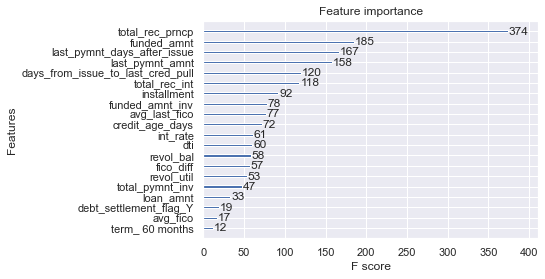

In [554]:
xgb.plot_importance(xgb_model)

In [555]:
cv_test = cross_val_score(xgb_model,x_test,y_test,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_test

array([0.96590909, 0.97529644, 0.97727273, 0.97529644, 0.96393281,
       0.97727273, 0.97727273, 0.95454545, 0.99802372, 0.97529644,
       0.97727273, 0.97727273, 1.        , 0.98863636, 1.        ,
       0.96590909, 0.96590909, 0.95348837, 0.97674419, 0.95151209])

In [556]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych testowych: {round(np.mean(cv_test),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych testowych: {round(cv_test.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych testowych: 0.9748
Standardowe odchylenie auroc dla 20k cross-walidacji na danych testowych: 0.0138


In [358]:
models.loc[models.index==6,'Model']='XGB Gradient Boosting'
models.loc[models.index==6,'AUROC_train']=metrics.roc_auc_score(y_train,xgb_model.predict(x_train))
models.loc[models.index==6,'CV_AUROC_train_avg']=np.mean(cv_auroc_score)
models.loc[models.index==6,'CV_AUROC_train_std']=cv_auroc_score.std()
models.loc[models.index==6,'AUROC_test']=metrics.roc_auc_score(y_test, xgb_model.predict(x_test))
models.loc[models.index==6,'CV_AUROC_test_avg']=np.mean(cv_test)
models.loc[models.index==6,'CV_AUROC_test_std']=cv_test.std()

In [376]:
models.drop(index=[7,8,9],inplace=True,errors='ignore')
models

Model AUROC_train CV_AUROC_train_avg  \
0             Regresja logistyczna (zm.num)    0.788862            0.78838   
1       Regresja logistyczna (zm.num i kat)    0.797742           0.795614   
2      Drzewo decyzyjne (wszystkie zmienne)    0.977037           0.964512   
3  Drzewo decyzyjne (najważniejsze zmienne)    0.919495           0.918206   
4                                Las losowy    0.979327           0.961783   
5                 Support Vector Classifier    0.998289           0.998292   
6                     XGB Gradient Boosting           1           0.986495   

  CV_AUROC_train_std AUROC_test CV_AUROC_test_avg CV_AUROC_test_std  
0          0.0157998   0.813378          0.812737         0.0333394  
1          0.0149405   0.816874          0.810094         0.0304088  
2         0.00887233   0.968403          0.934503         0.0190461  
3          0.0096406   0.923199          0.933102         0.0212874  
4         0.00761066   0.962273          0.941029         0.0192609  
5         0.00303448   0.977567          0.997615        0.00478375  
6         0.00516018   0.992391          0.974843         0.0137803

Wśród wytrenowanych modeli najlepszy wydaje się być model klasyfikacji wykorzystujący maszynę wektorów nośnych (svc). Ma najwyższy średni wskaźnik AUROC na danych testowych (0,9976), który jest zbliżonych do średniej tego wskaźnika na danych treningowych (0.998), a odchylenie standardowe tych wskaźników jest najmnniejsze w porównaniu do pozostałych modeli. Te wyniki wskazują na to, że model jest precyzyjnie wytrenowany oraz stabilny

<a id='pca'></a>
### PCA - Analiza głównych składowych numerycznych

In [377]:
loan_num_std_df

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  \
0      -0.702253    -0.695708        -0.587835 -0.277885    -0.625408   
2      -1.210933    -1.224977        -1.114201  1.283536    -1.134146   
3       0.275978     0.322118         0.439346  0.557225     0.517471   
4      -1.093545    -1.102838        -0.991553  0.321983    -1.241282   
5      -0.702253    -0.695708        -0.582724 -1.086530    -0.666928   
...          ...          ...              ...       ...          ...   
42507  -1.289191    -1.306403        -1.395270  0.354329    -1.245104   
42508  -0.506607    -0.492143        -1.359498  0.448426    -0.368642   
42509  -0.633777    -0.624460        -1.477036  0.448426    -0.510757   
42513  -0.506607    -0.492143        -1.471926 -0.295528    -0.415474   
42514  -0.819641    -0.817847        -1.318615 -0.574878    -0.765450   

       annual_inc       dti  open_acc  revol_bal  revol_util  ...  \
0       -1.228285  2.154261 -1.440722   0.566664    1.267514  ...   
2       -1.677740 -0.657324 -1.694751  -0.777294    1.792249  ...   
3       -0.264182  1.018042  0.337484  -0.445201   -0.955522  ...   
4        0.914166  0.712079  1.607631   2.343399    0.210951  ...   
5       -0.769188 -0.288981  0.083454  -0.147926   -0.696700  ...   
...           ...       ...       ...        ...         ...  ...   
42507   -1.763897 -1.435597 -1.694751  -1.077082    0.494592  ...   
42508   -1.687381 -1.298954  1.607631  -0.488818    0.047858  ...   
42509   -1.993446  0.275415 -1.948781  -1.148856    0.037221  ...   
42513   -1.381317 -0.036488 -0.932663   0.568173    0.639958  ...   
42514   -0.998737 -1.399951 -1.186693  -0.709794    0.551320  ...   

       total_pymnt_inv  total_rec_prncp  total_rec_int  last_pymnt_amnt  \
0            -0.459664        -0.507345      -0.511868        -0.636372   
2            -0.952313        -1.041075      -0.716056        -0.371915   
3             0.654834         0.519059       0.560069        -0.533606   
4            -0.767452        -0.917907      -0.350296        -0.694053   
5            -0.494787        -0.507345      -0.695010        -0.642228   
...                ...              ...            ...              ...   
42507        -1.259916        -1.123188      -0.863989        -0.693495   
42508        -1.221898        -0.302064      -0.173197        -0.618109   
42509        -1.343877        -0.435497      -0.306792        -0.146859   
42513        -1.343220        -0.302064      -0.379668        -0.622140   
42514        -1.194059        -0.630514      -0.653370        -0.652042   

       last_pymnt_days_after_issue  credit_age_days  \
0                         0.577870         2.615261   
2                         0.043215        -0.377273   
3                         0.577870         0.644900   
4                         2.404190         0.659990   
5                         0.577870        -0.910750   
...                            ...              ...   
42507                     0.500420        -1.592198   
42508                     0.500420        -1.710965   
42509                     0.125662        -2.066292   
42513                     0.500420        -0.140226   
42514                     0.500420        -1.651095   

       days_from_issue_to_last_cred_pull  avg_fico  avg_last_fico  fico_diff  
0                               0.515587  0.650834       0.622302   0.339433  
2                               0.019899  0.650834       0.622302   0.339433  
3                              -0.475788 -0.600884      -1.174482  -0.968409  
4                               0.373629 -0.461804      -0.109721   0.121460  
5                              -0.119731  0.511754      -1.706862  -2.130935  
...                                  ...       ...            ...        ...  
42507                           2.393614 -1.852602       0.356111   1.356644  
42508                          -0.119731 -1.574442      -0.375911   0.412091  
42509                       

In [379]:
pca=PCA(random_state=0)

In [380]:
pca.fit(loan_num_std_df)

PCA(random_state=0)

In [381]:
pca.explained_variance_ratio_

array([3.36141521e-01, 1.32056004e-01, 1.00308571e-01, 7.94965658e-02,
       6.75700210e-02, 4.84712615e-02, 4.46292888e-02, 4.13518374e-02,
       3.41159419e-02, 2.97680758e-02, 2.14004505e-02, 1.61984288e-02,
       1.44275445e-02, 1.11227185e-02, 8.75647819e-03, 6.66314101e-03,
       4.37195751e-03, 1.96320848e-03, 7.27378016e-04, 3.08304732e-04,
       1.51300930e-04, 3.89410119e-33])

In [384]:
var = np.cumsum(pca.explained_variance_ratio_)
var

array([0.33614152, 0.46819753, 0.5685061 , 0.64800266, 0.71557268,
       0.76404394, 0.80867323, 0.85002507, 0.88414101, 0.91390909,
       0.93530954, 0.95150797, 0.96593551, 0.97705823, 0.98581471,
       0.99247785, 0.99684981, 0.99881302, 0.99954039, 0.9998487 ,
       1.        , 1.        ])

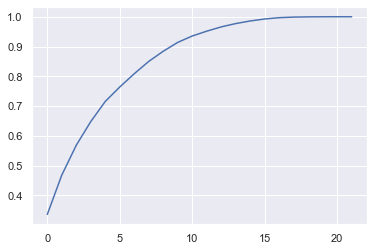

In [385]:
plt.plot(var)

In [450]:
pca_2=PCA(random_state=0, n_components=6)

In [451]:
loan_num_pca = pca_2.fit_transform(loan_num_std_df)

In [452]:
loan_num_pca_df = pd.DataFrame(loan_num_pca,index=loan_num_std_df.index)

<a id='pc_models'></a>
### Modele ze zmiennymi PC

In [480]:
models_pca = pd.DataFrame(index=range(0,10),columns=('Model','AUROC_train','AUROC_test'))

In [481]:
x = loan_num_pca
y = loan.if_charged_off
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)
print(f'Rozmiar treningowy: {x_train.shape}')
print(f'Rozmiar testowy: {x_test.shape}')

Rozmiar treningowy: (23723, 6)
Rozmiar testowy: (5931, 6)


In [482]:
logistic_pc = LogisticRegression(max_iter=300)

In [483]:
logistic_pc.fit(x_train,y_train)
logistic_pc.score(x_train,y_train)

0.8882940606162796

<AxesSubplot:>

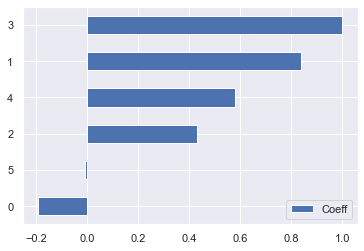

In [484]:
pd.DataFrame(logistic_pc.coef_[0],columns=['Coeff']).sort_values(by='Coeff').plot.barh()

In [485]:
models_pca.loc[models_pca.index==0,'Model']='Regresja logistyczna (pc)'
models_pca.loc[models_pca.index==0,'AUROC_train']=metrics.roc_auc_score(y_train,logistic_pc.predict(x_train))
models_pca.loc[models_pca.index==0,'AUROC_test']=metrics.roc_auc_score(y_test, logistic_pc.predict(x_test))

In [487]:
dtree_pc = tree.DecisionTreeClassifier(max_depth=10)

In [488]:
dtree_pc.fit(x_train,y_train)
dtree_pc.score(x_train,y_train)

0.9365594570669814

In [489]:
models_pca.loc[models_pca.index==1,'Model']='Drzewo decyzyjne (pc)'
models_pca.loc[models_pca.index==1,'AUROC_train']=metrics.roc_auc_score(y_train,dtree_pc.predict(x_train))
models_pca.loc[models_pca.index==1,'AUROC_test']=metrics.roc_auc_score(y_test, dtree_pc.predict(x_test))

In [492]:
random_forest_pc = RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,n_jobs=-1)

In [493]:
random_forest_pc.fit(x_train,y_train)
random_forest_pc.score(x_train,y_train)

0.9352105551574421

In [494]:
models_pca.loc[models_pca.index==2,'Model']='Las losowy (pc)'
models_pca.loc[models_pca.index==2,'AUROC_train']=metrics.roc_auc_score(y_train,random_forest_pc.predict(x_train))
models_pca.loc[models_pca.index==2,'AUROC_test']=metrics.roc_auc_score(y_test, random_forest_pc.predict(x_test))

In [477]:
svc_pc = SVC(C=100, kernel='linear')

In [478]:
svc_pc.fit(x_train,y_train)
svc_pc.score(x_train,y_train)

0.8891792774944147

In [496]:
models_pca.loc[models_pca.index==3,'Model']='Support Vector Classifier (pc)'
models_pca.loc[models_pca.index==3,'AUROC_train']=metrics.roc_auc_score(y_train,svc_pc.predict(x_train))
models_pca.loc[models_pca.index==3,'AUROC_test']=metrics.roc_auc_score(y_test, svc_pc.predict(x_test))

In [498]:
xgb_pc = xgb.XGBClassifier(use_label_encoder=False, verbosity=0)

In [499]:
xgb_pc.fit(x_train,y_train)
xgb_pc.score(x_train,y_train)

0.9573831302954938

In [500]:
models_pca.loc[models_pca.index==4,'Model']='XGB Gradient Boosting (pc)'
models_pca.loc[models_pca.index==4,'AUROC_train']=metrics.roc_auc_score(y_train,xgb_pc.predict(x_train))
models_pca.loc[models_pca.index==4,'AUROC_test']=metrics.roc_auc_score(y_test, xgb_pc.predict(x_test))

In [503]:
models_pca.drop(index=[5,6,7,8,9],inplace=True)
models_pca

Model AUROC_train AUROC_test
0       Regresja logistyczna (pc)    0.721876   0.735135
1           Drzewo decyzyjne (pc)    0.868034   0.792064
2                 Las losowy (pc)    0.836016   0.793528
3  Support Vector Classifier (pc)    0.714147   0.729504
4      XGB Gradient Boosting (pc)     0.89946   0.813365

Żaden z modeli zbudowanych na zmiennych z transformacji PCA nie przewyższył wyniku modelu SVC zbudowanego na zmiennych nietransformowanych 

<a id='final'></a>
### Finalny model

In [504]:
x = loan_num_cat[features]
y = loan.if_charged_off
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)
print(f'Rozmiar treningowy: {x_train.shape}')
print(f'Rozmiar testowy: {x_test.shape}')

Rozmiar treningowy: (23723, 20)
Rozmiar testowy: (5931, 20)


In [505]:
final_model = SVC(C=100, kernel='linear')

In [507]:
final_model.fit(x_train,y_train)
final_model.score(x_test, y_test)

0.9996627887371439

In [508]:
cv_test = cross_val_score(final_model,x_test,y_test,cv=kfold, scoring=metrics.make_scorer(metrics.roc_auc_score))
cv_test

array([1.        , 1.        , 0.98666008, 0.98863636, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.98863636, 0.98837209, 1.        , 1.        ])

In [509]:
print(f'Średni wskażnik auroc dla 20k cross-walidacji na danych testowych: {round(np.mean(cv_test),4)}')
print(f'Standardowe odchylenie auroc dla 20k cross-walidacji na danych testowych: {round(cv_test.std(),4)}')

Średni wskażnik auroc dla 20k cross-walidacji na danych testowych: 0.9976
Standardowe odchylenie auroc dla 20k cross-walidacji na danych testowych: 0.0048


In [521]:
svc_coef = pd.DataFrame(final_model.coef_[0],index=x.columns,columns=['Coef']).sort_values('Coef')

<AxesSubplot:>

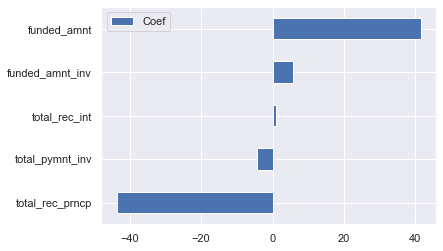

In [527]:
svc_coef[np.abs(svc_coef.Coef)>0.2].plot.barh()

In [529]:
print(metrics.classification_report(y_test, final_model.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5054
           1       1.00      1.00      1.00       877

    accuracy                           1.00      5931
   macro avg       1.00      1.00      1.00      5931
weighted avg       1.00      1.00      1.00      5931



<AxesSubplot:>

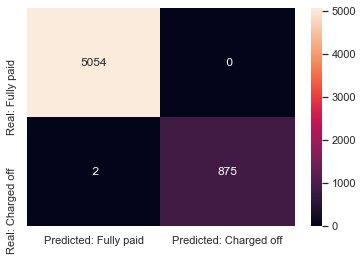

In [542]:
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, final_model.predict(x_test), labels=(0,1)),
             index=['Real: Fully paid','Real: Charged off'], 
                         columns=['Predicted: Fully paid','Predicted: Charged off']),annot=True,fmt='2d')

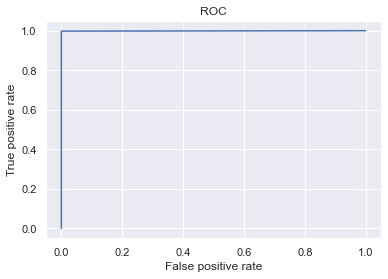

In [548]:
fpr, tpr, threshold = metrics.roc_curve(y_test, final_model.predict(x_test))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.show()

Finalny model to klasyfikator na podstawie algorytmu support vector machine z funkcją liniową oraz parametrem regularyzacji. Model na danych testowych tylko w 2 z 5931 obserwacji błędnie przewidział spłatę zobowiązania, podczas gdy w rzeczywistości był to kredyt niespłacony. Pozostałe obserwacje testowe zostały prawidłowo zakwalifikowane jako spłacone bądź niespłacone.
Średnia wartość AUROC dla 20-krotnej kros-walidacji na danych testowych to 0,9976 ze standardowym odchyleniem na poziomie 0.0048, co wskazuje na mały bias oraz małą wariancję modelu.